<a href="https://colab.research.google.com/github/YaninaK/car-insurance-renewal/blob/main/notebooks/03_Car_insurance_renewal_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Прогноз пролонгации полиса автострахования

## Модели

### [EDA и генерация новых признаков](https://github.com/YaninaK/car-insurance-renewal/blob/main/notebooks/01_Car_insurance_renewal_EDA.ipynb)

### [Benchmark: AutoML (PyCaret)](https://github.com/YaninaK/car-insurance-renewal/blob/main/notebooks/02_Car_insurance_renewal_AutoML.ipynb)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install category_encoders -q
!pip install shap -q

In [3]:
import os
import random
import pandas as pd
import numpy as np
import category_encoders as ce
import joblib

import statsmodels.api as sm
import lightgbm as lgb
from lightgbm.callback import early_stopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    roc_auc_score, classification_report, f1_score #, precision_recall_curve
)
import shap
import matplotlib.pyplot as plt

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
SEED = 0
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)

In [6]:
PATH = '/content/drive/MyDrive/ML_projects/04_Car_insurance_renewal/'

## 1. Чтение данных

In [7]:
data_file = 'Задание (пролонгация).xlsx'
field_description = pd.read_excel(
    PATH + 'data/01_raw/' + data_file, 0, header=None
)
data = pd.read_excel(PATH + 'data/01_raw/'+ data_file, 1)

In [8]:
field_description

0                                                  1
0                id                                        ID договора
1            Filial                                     Филиал продажи
2           Type_ts                                             Тип ТС
3   passport_region                           Регион по серии паспорта
4               VIP                                         VIP клиент
5             Brand                                           Марка ТС
6             Model                                          Модель ТС
7     Yr_production                                     Год выпуска ТС
8               GAP                                    GAP застрахован
9           married                                               Брак
10              KBM                                                КБМ
11     KBM_prol_est                          Прогноз КБМ (пролонгация)
12        delta_kbm                                      Изменение КБМ
13           deduct                                       Тип франшизы
14    deduct_amount  Сумма франшизы (0 -без франшизы;20000- - франш...
15          product                                            Продукт
16             Bank                              Машина в залоге банка
17    channel - map                                              Канал
18         category                                        Тип бизнеса
19         kvs_type                                            Тип ЛДУ
20              Age                                            Возраст
21              Exp                                               Стаж
22         discount                                      Скидка к СППГ
23      Amount - gr                   Страховая сумм (сгруппированная)
24              sex                                                Пол
25      premium_car                                     Премиальное ТС
26         price_gr                       Сгруппированный тариф (руб.)
27        price_prc    Сгруппированный тариф (премия к сумме покрытия)
28       OSAGO_clnt                                       Клиент ОСАГО
29           target  Таргет (0 - не пролонгирован; 1 - пролонгирова...

In [9]:
print(f'data.shape = {data.shape}\n')
data.sample(5)

data.shape = (10863, 30)



ID         Filial      Type_ts        passport_region  VIP    Brand  \
2657    2658     Московский  Иностранные     Московская область  NaN  HYUNDAI   
4238    4239     Московский  Иностранные                 Москва  NaN   NISSAN   
7422    7423      Казанский  Иностранные   Республика Татарстан  NaN      KIA   
10687  10688     Московский  Иностранные                 Москва  NaN    SKODA   
7748    7749  Нижегородский  Иностранные  Нижегородская область  NaN  HYUNDAI   

         Model  Yr_production  GAP             married  ...  Age  Exp  \
2657   SOLARIS           2018  Нет     Состоит в браке  ...   48   19   
4238   QASHQAI           2018   Да     Состоит в браке  ...   37   12   
7422       RIO           2017  Нет     Состоит в браке  ...   29    6   
10687    RAPID           2018  Нет  Не состоит в браке  ...   35   17   
7748    TUCSON           2018  Нет     Состоит в браке  ...   60   41   

       discount Amount - gr sex premium_car price_gr price_prc OSAGO_clnt  \
2657        0.9      800000   F           0    40000     0.050          0   
4238        1.0     1600000   F           0    35000     0.020          1   
7422        1.0      200000   F           0    10000     0.030          0   
10687       1.0      800000   F           0    40000     0.045          0   
7748        1.0     1200000   M           0    35000     0.025          1   

      target  
2657       0  
4238       1  
7422       1  
10687     -1  
7748      -1  

[5 rows x 30 columns]

In [10]:
TARGET_NAME = 'target'

## 2. Разделение на обучающую и тестовую выбоки

In [11]:
train = data[data[TARGET_NAME] != -1]
train.shape

(7598, 30)

In [12]:
test = data[data[TARGET_NAME] == -1]
test.shape

(3265, 30)

In [13]:
train['premium_car'].value_counts()

0    6925
1     673
Name: premium_car, dtype: int64

## 3. Подготовка данных

In [14]:
def data_preparation_pipeline(train):
  train, vars_to_scale = generate_numeric_features(train)
  scaler = MinMaxScaler()
  train[vars_to_scale] = scaler.fit_transform(train[vars_to_scale])

  categorical_vars = train.dtypes[train.dtypes == 'object'].index.tolist()
  count_encoder = ce.CountEncoder(cols=categorical_vars, normalize=True, )
  df = count_encoder.fit_transform(train)[categorical_vars]
  df.columns = [f'{col}_count' for col in categorical_vars]
  vars_to_drop = [
      'deduct_count', 'Brand_count', 'married_count', 'passport_region_count'
  ]
  df.drop(vars_to_drop, axis=1, inplace=True)

  train = generate_categorical_features(train)
  same_regions_list = get_same_regions_list(train)
  train = get_diff_passport_region_feature(train, same_regions_list)

  glmm_encoder = ce.glmm.GLMMEncoder(
      cols=[
          'Filial',
          'Brand',
          'Model',
          'product',
          'Bank',
          'sex_mariage',
          'category',
      ]
  )
  train = glmm_encoder.fit_transform(train, y=train[TARGET_NAME])
  train = pd.concat([train, df], axis=1)
  train.fillna(0, inplace=True)
  train['intercept'] = 1

  return train, scaler, same_regions_list, count_encoder, glmm_encoder


def data_preparation_pipeline_inference(
    test, scaler, same_regions_list, count_encoder, glmm_encoder
):
  test, vars_to_scale = generate_numeric_features(test)
  test[vars_to_scale] = scaler.transform(test[vars_to_scale])

  categorical_vars = test.dtypes[test.dtypes == 'object'].index.tolist()
  df = count_encoder.transform(test)[categorical_vars]
  df.columns = [f'{col}_count' for col in categorical_vars]
  vars_to_drop = [
      'deduct_count', 'Brand_count', 'married_count', 'passport_region_count'
  ]
  df.drop(vars_to_drop, axis=1, inplace=True)

  test = generate_categorical_features(test)
  test = get_diff_passport_region_feature(test, same_regions_list)
  test = glmm_encoder.transform(test)
  test = pd.concat([test, df], axis=1)
  test.fillna(0, inplace=True)
  test['intercept'] = 1

  return test


def generate_numeric_features(train):
  train['KBM_1'] = np.where(train['KBM'] <= 3, train['KBM'], 0)

  train['price_gr_1'] = np.where(train['price_gr'] < 1.5e4, 1, 0)
  train['price_gr_2'] = np.where(
      (train['price_gr'] >= 1.5e4) & (train['price_gr'] <= 4e4), train['price_gr'], 0
  )
  bins = [4e4,  5e4, 6e4, 7e4]
  train['price_gr_3'] = pd.cut(train['price_gr'], bins, labels=bins[1:])

  bins = [-1, 0.02, 0.03, 0.04, 0.05, 0.06, 0.1]
  train['price_prc'] = pd.cut(
      train['price_prc'], bins, labels=bins[1:]
  )
  for var in ['price_gr_3', 'price_prc']:
    train[var] = train[var].astype(float)

  drop_features = ['KBM', 'KBM_prol_est', 'price_gr']
  vars_to_scale = [
      'Yr_production',
      'KBM_1',
      'Age',
      'Exp',
      'discount',
      'Amount - gr',
      'price_gr_2',
      'price_gr_3',
      'price_prc',
  ]

  return train.drop(drop_features, axis=1), vars_to_scale


def generate_categorical_features(data):
  data = merge_features(data, 'sex', 'married', 'sex_mariage')
  drop_features = drop_features = [
      'Type_ts',
      'VIP',
      'GAP',
      'married',
      'deduct',
      'deduct_amount',
      'channel - map',
      'kvs_type',
      'sex'
  ]

  return data.drop(drop_features, axis=1)


def get_same_regions_list(data):
  train = data.copy()
  train = merge_features(train, 'Filial', 'passport_region', 'merged')
  regions = train['merged'].value_counts().head(27).index.tolist()
  exclude_list = [
    'Магнитогорский Республика Башкортостан',
    'Краснодарский Республика Адыгея',
    'Московский Краснодарский край'
  ]
  same_regions_list = [i for i in regions if not i in exclude_list]

  return same_regions_list


def get_diff_passport_region_feature(data, same_regions_list):
  data = merge_features(data, 'Filial', 'passport_region', 'merged')
  new_feature = 'diff_passport_region'
  data[new_feature] = 0
  data.loc[data['merged'].isin(same_regions_list), new_feature] = 1
  data.drop(['passport_region', 'merged'], axis=1, inplace=True)

  return data

def merge_features(data, feature_1, feature_2, new_feature):
  data.loc[:, new_feature] = (
    data.loc[:, [feature_1, feature_2]]
    .apply(lambda x: ''.join(str(x.values))[1:-1].replace("'", ""), axis=1)
  )

  return data


def get_same_regions_list(data):
  train = data.copy()
  train = merge_features(train, 'Filial', 'passport_region', 'merged')
  regions = train['merged'].value_counts().head(27).index.tolist()
  exclude_list = [
    'Магнитогорский Республика Башкортостан',
    'Краснодарский Республика Адыгея',
    'Московский Краснодарский край'
  ]
  same_regions_list = [i for i in regions if not i in exclude_list]

  return same_regions_list


def get_diff_passport_region_feature(data, same_regions_list):
  data = merge_features(data, 'Filial', 'passport_region', 'merged')
  new_feature = 'diff_passport_region'
  data[new_feature] = 0
  data.loc[data['merged'].isin(same_regions_list), new_feature] = 1

  return data.drop(['passport_region', 'merged'], axis=1)

In [15]:
regenerate = True
if regenerate:
  (
      train, scaler, same_regions_list, count_encoder, glmm_encoder
  ) = data_preparation_pipeline(train)
  joblib.dump(scaler, PATH + 'data/02_intermediate/' + 'scaler.joblib')
  joblib.dump(
      same_regions_list, PATH + 'data/02_intermediate/' + 'same_regions_list.joblib'
  )
  joblib.dump(count_encoder, PATH + 'data/02_intermediate/' + 'count_encoder.joblib')
  joblib.dump(glmm_encoder, PATH + 'data/02_intermediate/' + 'glmm_encoder.joblib')
  train.to_parquet(
      PATH + 'data/03_model_input/' + 'train_dataset.parquet.gz', compression='gzip'
  )
else:
  scaler = joblib.load(PATH + 'data/02_intermediate/' + 'scaler.joblib')
  same_regions_list = joblib.load(
      PATH + 'data/02_intermediate/' + 'same_regions_list.joblib'
  )
  count_encoder = joblib.load(PATH + 'data/02_intermediate/' + 'count_encoder.joblib')
  glmm_encoder = joblib.load(PATH + 'data/02_intermediate/' + 'glmm_encoder.joblib')
  train = pd.read_parquet(
      PATH + 'data/03_model_input/' + 'train_dataset.parquet.gz'
  )

In [16]:
regenerate = True
if regenerate:
  test = data_preparation_pipeline_inference(
    test, scaler, same_regions_list, count_encoder, glmm_encoder
)
  test.to_parquet(
      PATH + 'data/03_model_input/' + 'test_dataset.parquet.gz', compression='gzip'
  )
else:
  test = pd.read_parquet(PATH + 'data/03_model_input/'+ 'test_dataset.parquet.gz')

## 4. Модели

In [17]:
cols = [col for col in train.columns if not col in ['ID', TARGET_NAME]]
df_selected_features = pd.DataFrame(index=cols)
df_aic = pd.DataFrame()
df_auc = pd.DataFrame()
results = train[[TARGET_NAME]]
selected_models = []

### 4.1 Logit

#### 4.1.1. Отбор признаков

In [18]:
n_splits = 10
cv = StratifiedKFold(n_splits=n_splits)
X = train[cols]
y = train[TARGET_NAME]

selected = pd.DataFrame(index=cols)
aucs = []
for fold, (idx_train, idx_test) in enumerate(cv.split(X, y)):
  model = sm.Logit(y[idx_train], X.loc[idx_train]).fit(method='lbfgs')
  selected.loc[:, f'{fold}'] = np.where(model.pvalues < 0.05, 1, 0)

  y_pred = model.predict(X.loc[idx_test])
  aucs.append(roc_auc_score(y[idx_test], y_pred))

selected.loc['intercept', :] = 1
auc_mean = np.array(aucs).mean()
auc_std = np.array(aucs).std()
print(f'\nauc: {round(auc_mean, 4)} +/- {round(auc_std, 4)}')


auc: 0.7477 +/- 0.0198


In [19]:
selected[selected.mean(axis=1) == 1]

0  1  2  3  4  5  6  7  8  9
Filial               1  1  1  1  1  1  1  1  1  1
Model                1  1  1  1  1  1  1  1  1  1
product              1  1  1  1  1  1  1  1  1  1
Bank                 1  1  1  1  1  1  1  1  1  1
category             1  1  1  1  1  1  1  1  1  1
price_prc            1  1  1  1  1  1  1  1  1  1
OSAGO_clnt           1  1  1  1  1  1  1  1  1  1
deduct_amount_count  1  1  1  1  1  1  1  1  1  1
intercept            1  1  1  1  1  1  1  1  1  1

In [20]:
df_selected_features['Logit'] = np.where(selected.mean(axis=1) == 1, 1, 0)

#### 4.1.2. Кросс-валидация

In [21]:
n_splits = 10
cv = StratifiedKFold(n_splits=n_splits)

features_logit = df_selected_features[df_selected_features['Logit'] == 1].index.tolist()
X = train[features_logit]
y = train[TARGET_NAME]

aic = []
models_logit = []
aucs = []
for fold, (idx_train, idx_test) in enumerate(cv.split(X, y)):
    log_reg = sm.Logit(y[idx_train], X.loc[idx_train]).fit(method='ncg')
    models_logit.append(log_reg)
    aic.append(log_reg.aic)
    print(log_reg.summary2())
    y_pred = log_reg.predict(X.loc[idx_test])
    results.loc[idx_test, 'Logit'] = y_pred
    aucs.append(roc_auc_score(y[idx_test], y_pred))

df_aic['Logit'] = aic
df_auc['Logit'] = aucs

auc_mean = np.array(aucs).mean()
auc_std = np.array(aucs).std()
print(f'\nauc: {round(auc_mean, 4)} +/- {round(auc_std, 4)}')

Optimization terminated successfully.
         Current function value: 0.534431
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
         Hessian evaluations: 7
                           Results: Logit
Model:                Logit            Pseudo R-squared: 0.139      
Dependent Variable:   target           AIC:              7326.8771  
Date:                 2023-08-29 20:11 BIC:              7388.3493  
No. Observations:     6838             Log-Likelihood:   -3654.4    
Df Model:             8                LL-Null:          -4245.5    
Df Residuals:         6829             LLR p-value:      6.9231e-250
Converged:            1.0000           Scale:            1.0000     
Method:               MLE                                           
--------------------------------------------------------------------
                     Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------

#### 4.1.3. Area Under the Curve (AUC)

In [22]:
df_auc.round(4)

Logit
0  0.7735
1  0.7616
2  0.7659
3  0.7747
4  0.7283
5  0.7277
6  0.7531
7  0.7629
8  0.7161
9  0.7204

In [23]:
df_auc.max()

Logit    0.774689
dtype: float64

#### 4.1.4. Akaike Information Criterion (AIC)

AIC = -2 * log liklihood + 2p

p - число параметров в модели

In [24]:
df_aic.round(1)

Logit
0  7326.9
1  7309.7
2  7318.0
3  7326.9
4  7275.0
5  7276.3
6  7304.6
7  7313.7
8  7263.4
9  7265.3

In [25]:
print(models_logit[np.argmax(aucs)].summary2())

                           Results: Logit
Model:                Logit            Pseudo R-squared: 0.139      
Dependent Variable:   target           AIC:              7326.9160  
Date:                 2023-08-29 20:11 BIC:              7388.3882  
No. Observations:     6838             Log-Likelihood:   -3654.5    
Df Model:             8                LL-Null:          -4245.5    
Df Residuals:         6829             LLR p-value:      7.0584e-250
Converged:            1.0000           Scale:            1.0000     
Method:               MLE                                           
--------------------------------------------------------------------
                     Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------
Filial               0.9000   0.0904   9.9524 0.0000  0.7228  1.0772
Model                0.8783   0.0823  10.6737 0.0000  0.7170  1.0396
product              0.5957   0.0869   6.8510 0.0000  0.4252 

#### 4.1.5. Deviance residuals

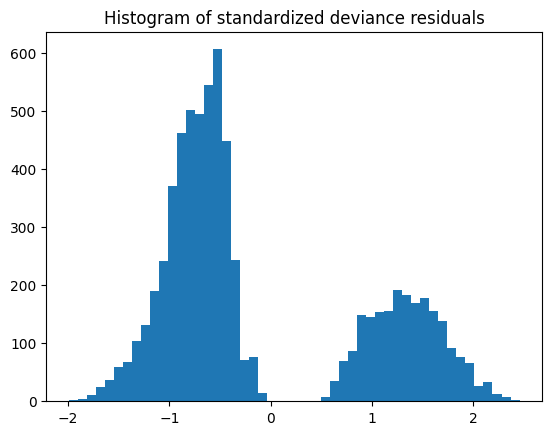

In [26]:
plt.hist(models_logit[np.argmax(aucs)].resid_dev, bins=50)
plt.title('Histogram of standardized deviance residuals');

* В обучающей выборке одна группа deviance residuals наиболее часто встречается около -0.75, а другая - около 1.25. Распределение deviance residuals отклоняется от норамального. Confidence-интервалы предсказаний вероятно не точны.

У обеих групп абсолютные значения стандартизованных deviance residuals больше 2.

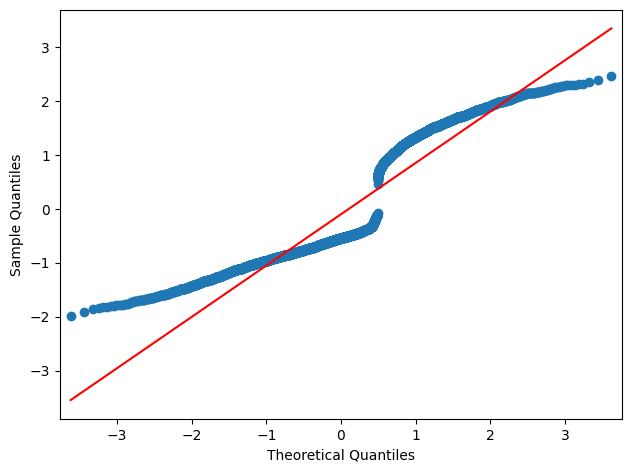

In [27]:
fig = sm.graphics.qqplot(models_logit[np.argmax(aucs)].resid_dev, line='r')
fig.tight_layout(pad=1.0)

* QQ-plot deviance residuals также говорит об отклонении от нормального распределения.

#### 4.1.6. Сохранение модели

In [28]:
save = True
if save:
  file_name = f'model_Logit_auc_{str(max(aucs))[2:6]}.joblib'
  model = models_logit[np.argmax(aucs)]
  joblib.dump(model,  PATH + 'models/' + file_name)

  print(file_name)

model_Logit_auc_7746.joblib


In [29]:
selected_models.append(file_name)

### 4.2 GLM

#### 4.2.1. Отбор признаков

In [30]:
n_splits = 10
cv = StratifiedKFold(n_splits=n_splits)
X = train[cols]
y = train[TARGET_NAME]

selected = pd.DataFrame(index=cols)
for fold, (idx_train, idx_test) in enumerate(cv.split(X, y)):
  model = sm.GLM(
      y[idx_train], X.loc[idx_train], family=sm.genmod.families.Binomial()
  ).fit(method='ncg')
  selected.loc[:, f'{fold}'] = np.where(model.pvalues < 0.05, 1, 0)
selected.loc['intercept', :] = 1

In [31]:
features_GLM = selected[selected.mean(axis=1) == 1].index.tolist()
features_GLM

['Filial',
 'Model',
 'product',
 'Bank',
 'category',
 'price_prc',
 'OSAGO_clnt',
 'KBM_1',
 'deduct_amount_count',
 'product_count',
 'intercept']

In [32]:
df_selected_features['GLM'] = np.where(selected.mean(axis=1) == 1, 1, 0)

#### 4.2.2. Кросс-валидация

In [33]:
n_splits = 10
cv = StratifiedKFold(n_splits=n_splits)
X = train[features_GLM]
aic_glm = []
models_glm = []
aucs_glm = []
for fold, (idx_train, idx_test) in enumerate(cv.split(X, y)):
  model = sm.GLM(
      y[idx_train], X.loc[idx_train], family=sm.genmod.families.Binomial()
  ).fit(method='ncg')
  models_glm.append(model)
  aic_glm.append(model.aic)
  print(models_glm[fold].summary2())
  y_pred = model.predict(X.loc[idx_test])
  results.loc[idx_test, 'GLM'] = y_pred
  aucs_glm.append(roc_auc_score(y[idx_test], y_pred))

df_aic['GLM'] = aic_glm
df_auc['GLM'] = aucs_glm

auc_mean = np.array(aucs_glm).mean()
auc_std = np.array(aucs_glm).std()
print(f'\nauc: {round(auc_mean, 4)} +/- {round(auc_std, 4)}')

                 Results: Generalized linear model
Model:                GLM               Method:          IRLS       
Link Function:        Logit             AIC:             7307.4697  
Dependent Variable:   target            BIC:             -52998.6509
Date:                 2023-08-29 20:11  Log-Likelihood:  -3642.7    
No. Observations:     6838              LL-Null:         -4245.5    
Df Model:             10                Deviance:        7285.5     
Df Residuals:         6827              Pearson chi2:    6.57e+03   
Converged:            1.0000            Scale:           1.0000     
--------------------------------------------------------------------
                     Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------
Filial               0.8343   0.0918   9.0871 0.0000  0.6544  1.0142
Model                0.8053   0.0850   9.4769 0.0000  0.6387  0.9718
product              0.7183   0.1272   5.6453 0.0000

#### 4.2.3. Area Under the Curve (AUC)

In [34]:
df_auc.round(4)

Logit     GLM
0  0.7735  0.7773
1  0.7616  0.7587
2  0.7659  0.7680
3  0.7747  0.7728
4  0.7283  0.7320
5  0.7277  0.7294
6  0.7531  0.7526
7  0.7629  0.7623
8  0.7161  0.7227
9  0.7204  0.7218

In [35]:
df_auc.max().sort_values()

Logit    0.774689
GLM      0.777275
dtype: float64

#### 4.2.4. Akaike Information Criterion (AIC)

In [36]:
df_aic.round(1)

Logit     GLM
0  7326.9  7307.5
1  7309.7  7281.5
2  7318.0  7296.2
3  7326.9  7298.8
4  7275.0  7255.1
5  7276.3  7251.8
6  7304.6  7278.1
7  7313.7  7288.7
8  7263.4  7245.7
9  7265.3  7243.1

#### 4.2.5. Deviance residuals

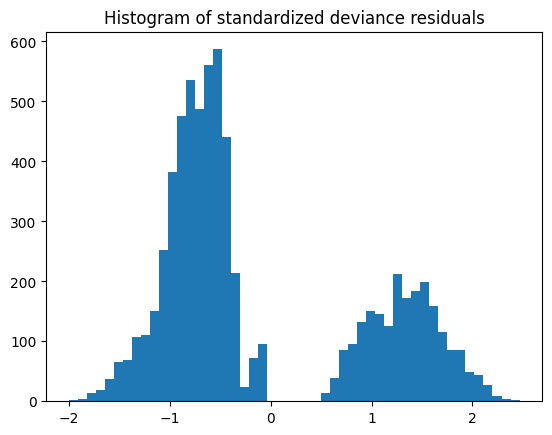

In [37]:
plt.hist(models_glm[np.argmax(aucs_glm)].resid_deviance, bins=50)
plt.title('Histogram of standardized deviance residuals');

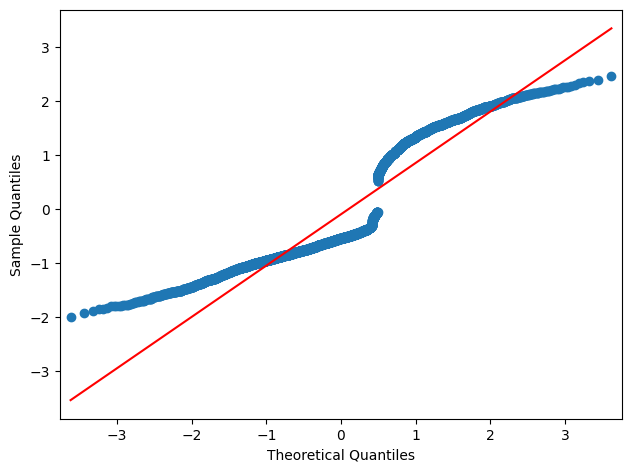

In [38]:
fig = sm.graphics.qqplot(models_glm[np.argmax(aucs_glm)].resid_deviance, line='r')
fig.tight_layout(pad=1.0)

#### 4.2.6. Influence

 Influence основана на одношаговой аппроксимации результатов удаления одного наблюдения. Одношаговые приближения обычно точны для небольших изменений, но недооценивают величину больших изменений.

Хотя большие изменения недооцениваются, influence все же ясно показывает влияние значимых наблюдений.

In [39]:
infl = models_glm[3].get_influence(observed=False)
summ_df = infl.summary_frame()
summ_df.sort_values("cooks_d", ascending=False).head(10)

dfb_Filial  dfb_Model  dfb_product  dfb_Bank  dfb_category  \
3181   -0.011358   0.035844     0.007965 -0.011286      0.003608   
5299   -0.000355   0.002000     0.008434 -0.005677      0.006986   
47     -0.020506  -0.036603    -0.046617  0.008660      0.002378   
3899   -0.007565  -0.045923    -0.044965  0.007459      0.010782   
7020   -0.008188  -0.035032    -0.045361  0.004059      0.003080   
4553   -0.021028  -0.003349    -0.048324  0.000594      0.001795   
3114   -0.009272  -0.029637    -0.038998  0.002000      0.010231   
4488   -0.020688   0.010797    -0.047301 -0.003022      0.009419   
1909   -0.012515  -0.000599    -0.046760 -0.002350      0.009540   
4916   -0.041596   0.085351     0.021223  0.017251     -0.030015   

      dfb_price_prc  dfb_OSAGO_clnt  dfb_KBM_1  dfb_deduct_amount_count  \
3181      -0.016701       -0.014470  -0.171822                -0.036127   
5299      -0.003858        0.028844  -0.163356                 0.014461   
47        -0.000389       -0.016127  -0.137097                -0.004796   
3899      -0.001927       -0.014531  -0.135203                -0.002465   
7020      -0.000232        0.035613  -0.131393                -0.002154   
4553       0.007389       -0.014859  -0.133162                -0.008197   
3114      -0.027760       -0.013342  -0.127226                -0.000834   
4488       0.010349       -0.014969  -0.128476                -0.007841   
1909       0.008266       -0.013592  -0.128874                -0.006948   
4916       0.110358        0.007460  -0.006113                -0.024969   

      dfb_product_count  dfb_intercept   cooks_d  standard_resid  hat_diag  \
3181          -0.007593       0.022586  0.003081       -1.581137  0.013377   
5299           0.009523      -0.017050  0.002704       -1.503989  0.012979   
47             0.022359       0.014481  0.002674       -2.973817  0.003315   
3899           0.023670       0.010927  0.002612       -2.695373  0.003939   
7020           0.022593       0.002917  0.002506       -2.377864  0.004852   
4553           0.013557       0.022011  0.002364       -2.520271  0.004077   
3114           0.030405       0.008998  0.002242       -2.163419  0.005242   
4488           0.010967       0.023489  0.002157       -2.143420  0.005137   
1909           0.012354       0.020971  0.002150       -2.183287  0.004937   
4916          -0.061175       0.022303  0.002150        1.546961  0.009784   

      dffits_internal  
3181        -0.184109  
5299        -0.172465  
47          -0.171507  
3899        -0.169504  
7020        -0.166037  
4553        -0.161256  
3114        -0.157042  
4488        -0.154024  
1909        -0.153787  
4916         0.153774

##### Cook's distance

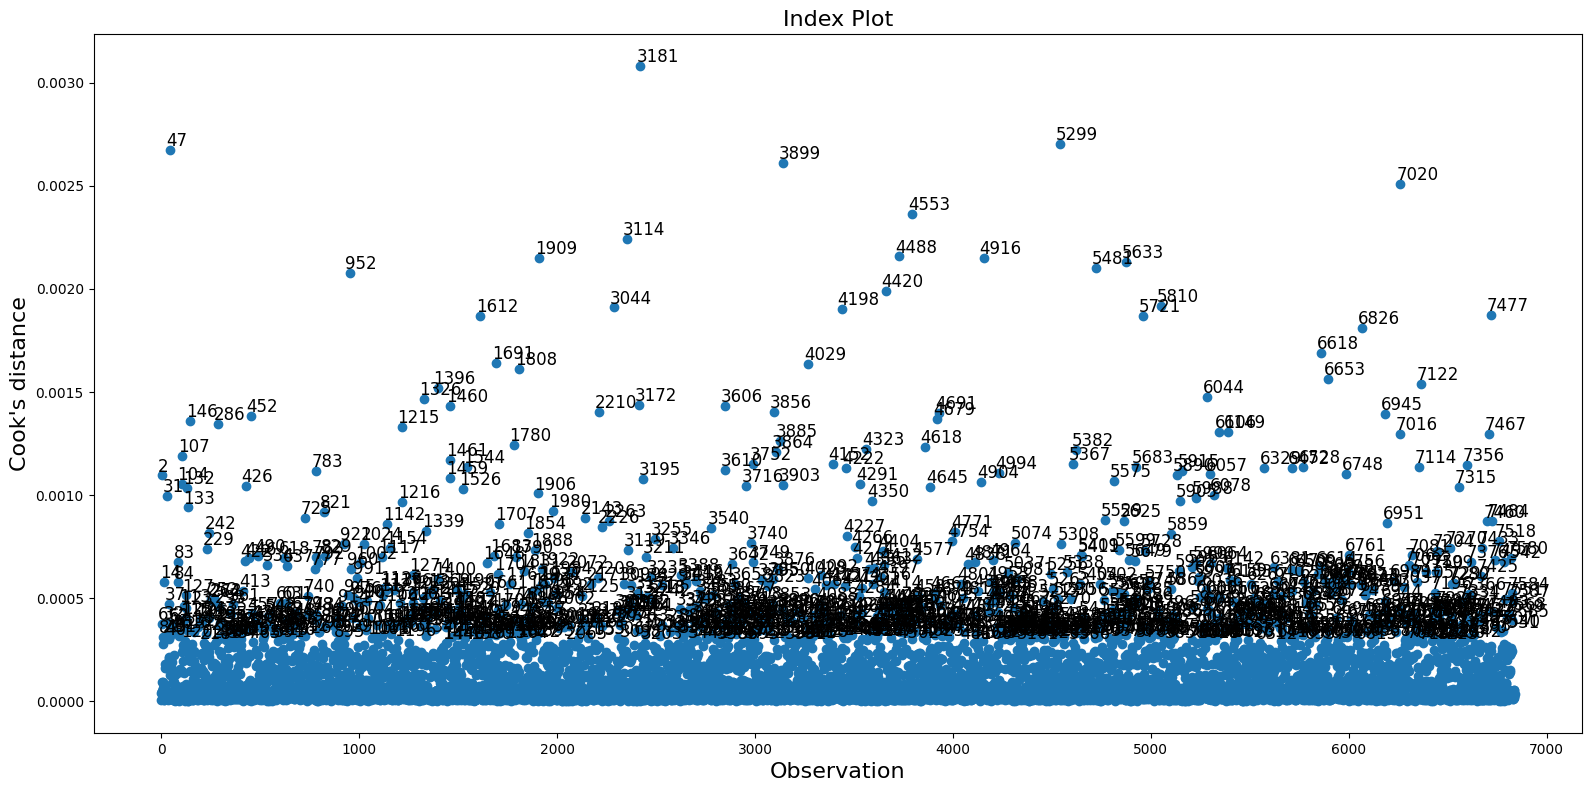

In [40]:
plt.rc("figure", figsize=(16, 8))

fig = infl.plot_index(
    y_var="cooks_d", threshold=2 * infl.cooks_distance[0].mean()
)
fig.tight_layout(pad=1.0)

In [41]:
ind = summ_df.sort_values("cooks_d", ascending=False)['cooks_d'].index[:10]
data.loc[ind, :]

ID           Filial      Type_ts      passport_region  VIP  \
3181  3182       Московский  Иностранные   Московская область  NaN   
5299  5300       Московский  Иностранные               Москва  NaN   
47      48       Московский  Иностранные      Санкт-Петербург  NaN   
3899  3900      Воронежский  Иностранные   Мурманская область  NaN   
7020  7021       Московский  Иностранные               Москва  NaN   
4553  4554       Московский  Иностранные   Московская область  NaN   
3114  3115      Челябинский  Иностранные  Челябинская область  NaN   
4488  4489       Московский  Иностранные               Москва  NaN   
1909  1910  Дальневосточный  Иностранные      Приморский край  NaN   
4916  4917    Краснодарский  Иностранные   Краснодарский край  NaN   

              Brand     Model  Yr_production  GAP          married  ...  Age  \
3181        HYUNDAI   SOLARIS           2015  Нет  Состоит в браке  ...   46   
5299        RENAULT   SANDERO           2015  Нет  Состоит в браке  ...   38   
47             AUDI        Q5           2014  Нет  Состоит в браке  ...   53   
3899          VOLVO      XC60           2015  Нет  Состоит в браке  ...   60   
7020         NISSAN   QASHQAI           2015  Нет  Состоит в браке  ...   35   
4553  MERCEDES-BENZ       GLA           2015  Нет  Состоит в браке  ...   44   
3114        RENAULT    DUSTER           2014   Да  Состоит в браке  ...   36   
4488            KIA  SPORTAGE           2012  Нет  Состоит в браке  ...   51   
1909            BMW        X3           2015  Нет  Состоит в браке  ...   56   
4916         NISSAN      JUKE           2013  Нет  Состоит в браке  ...   64   

      Exp  discount Amount - gr sex premium_car price_gr price_prc OSAGO_clnt  \
3181    8      0.95      400000   M           0    30000     0.060          1   
5299   15      0.95      400000   F           0    20000     0.040          0   
47     13      1.10     1200000   M           1    25000     0.015          1   
3899   30      0.95     2000000   F           1    25000     0.010          1   
7020   14      1.00      800000   M           0    15000     0.020          0   
4553   15      1.05     1400000   M           1    30000     0.020          1   
3114    7      0.90      600000   M           0    25000     0.035          1   
4488   32      1.05      800000   M           0    15000     0.020          1   
1909   37      0.95     1600000   M           1    30000     0.015          1   
4916   33      1.00      400000   F           0    35000     0.065          1   

     target  
3181      0  
5299      0  
47        0  
3899      0  
7020      0  
4553      0  
3114      0  
4488      0  
1909      0  
4916      1  

[10 rows x 30 columns]

* Это 10 экземпляров обучающей выборки, наиболее влияющих на модель. Если их убрать, модель может существенно измениться.
* Вопрос, включать ли в модель экземпляры с самой большой Cook's distance нуждается в дальнейшей проработке. Возможно, линейная модель не может схватить все закономерности и требуется последовательная линейная комбинация с деревянной моделью.


##### Residuals

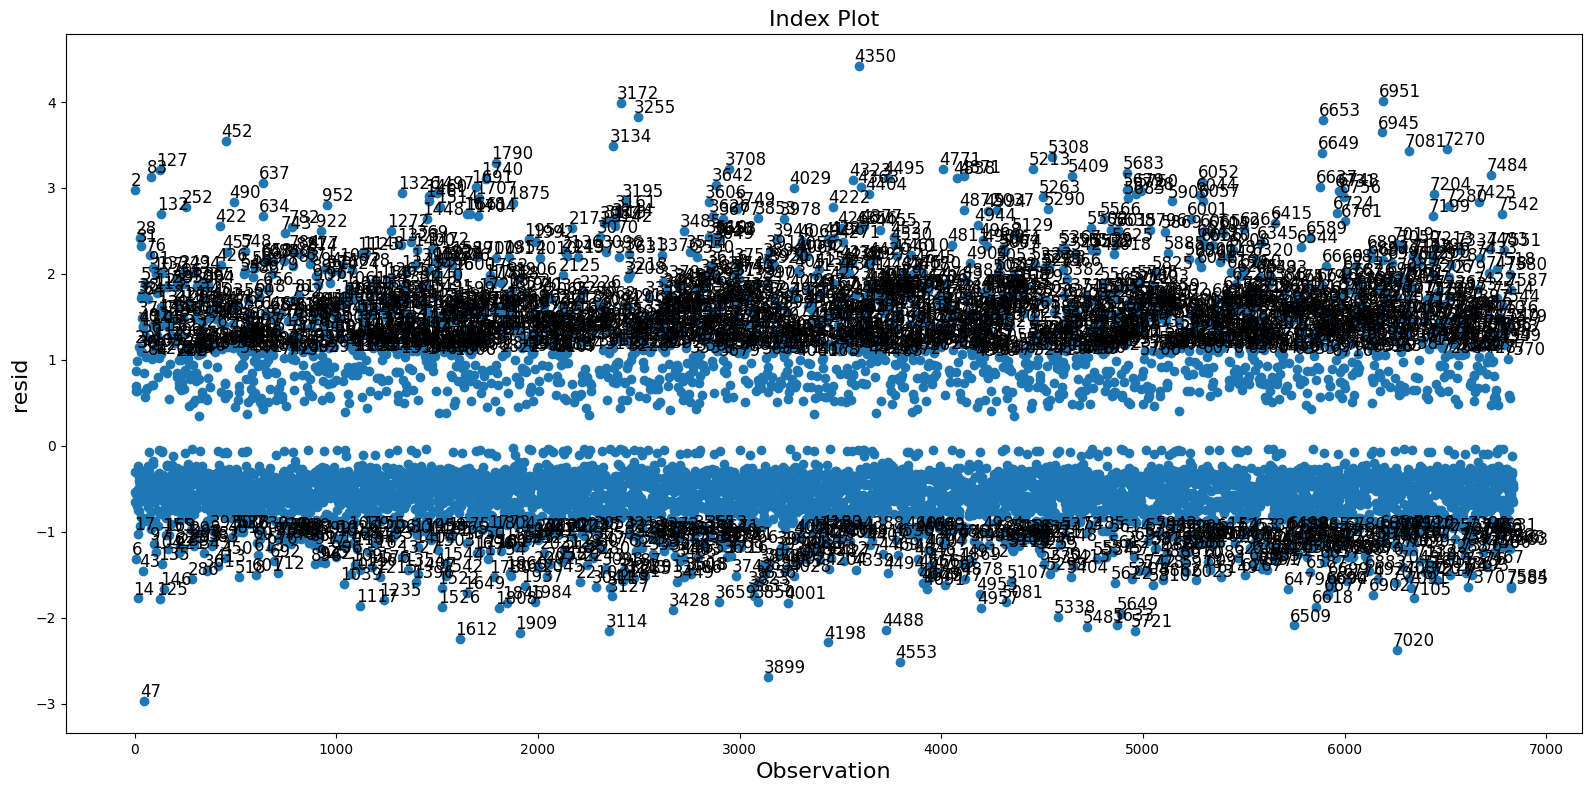

In [42]:
fig = infl.plot_index(y_var="resid", threshold=1)
fig.tight_layout(pad=1.0)

In [43]:
ind_res = summ_df.sort_values(
    "standard_resid", ascending=False
)['standard_resid'].index[:10]
data.loc[ind_res, :]

ID                 Filial        Type_ts        passport_region  VIP  \
4350  4351          Краснодарский  Отечественные      Республика Адыгея  NaN   
6951  6952          Краснодарский    Иностранные     Краснодарский край  NaN   
3172  3173               Пермский    Иностранные          Пермский край  NaN   
3255  3256          Краснодарский  Отечественные     Краснодарский край  NaN   
6653  6654  Санкт - Петербургский    Иностранные  Ленинградская область  NaN   
6945  6946          Краснодарский    Иностранные   Свердловская область  NaN   
452    453          Краснодарский    Иностранные     Краснодарский край  NaN   
3134  3135          Нижегородский    Иностранные  Нижегородская область  NaN   
7270  7271         Магнитогорский  Отечественные   Оренбургская область  NaN   
7081  7082          Краснодарский    Иностранные     Краснодарский край  NaN   

           Brand   Model  Yr_production  GAP             married  ...  Age  \
4350        LADA  GRANTA           2018  Нет  Не состоит в браке  ...   60   
6951  VOLKSWAGEN    POLO           2018  Нет     Состоит в браке  ...   39   
3172  VOLKSWAGEN    POLO           2018  Нет     Состоит в браке  ...   26   
3255        LADA    XRAY           2018  Нет  Не состоит в браке  ...   41   
6653         KIA    CEED           2010  Нет  Не состоит в браке  ...   36   
6945      DATSUN   ON-DO           2018  Нет     Состоит в браке  ...   37   
452   VOLKSWAGEN    POLO           2018  Нет     Состоит в браке  ...   38   
3134      DATSUN   ON-DO           2018  Нет  Не состоит в браке  ...   45   
7270        LADA  GRANTA           2018   Да     Состоит в браке  ...   43   
7081      DATSUN   ON-DO           2018  Нет  Не состоит в браке  ...   49   

      Exp  discount Amount - gr sex premium_car price_gr price_prc OSAGO_clnt  \
4350   22      0.90      400000   M           0    20000     0.055          0   
6951   18      1.00      600000   M           0    35000     0.045          0   
3172    8      1.10      600000   F           0    45000     0.070          0   
3255    7      1.00      600000   F           0    35000     0.055          1   
6653   10      0.95      200000   M           0    35000     0.090          0   
6945    6      0.90      400000   F           0    45000     0.090          1   
452    18      0.90      600000   F           0    55000     0.080          1   
3134    7      1.00      400000   M           0    30000     0.060          0   
7270   19      1.00      600000   M           0    35000     0.055          0   
7081   11      1.00      400000   M           0    20000     0.040          1   

     target  
4350      1  
6951      1  
3172      1  
3255      1  
6653      1  
6945      1  
452       1  
3134      1  
7270      1  
7081      1  

[10 rows x 30 columns]

In [44]:
set(ind_res) & set(ind)

set()

In [45]:
summ_df[summ_df['standard_resid'] > 2].shape[0]

271

* Это 10 экземпляров обучающей выборки, на которых модель больше всего ошибается. 2 из них с индексами 452 и 6945 входят в top-10 с самой высокой Cook's distance.
* В обучающей выборке значительное количество экземпляров со standard_residual больше 2.

##### Influence plot

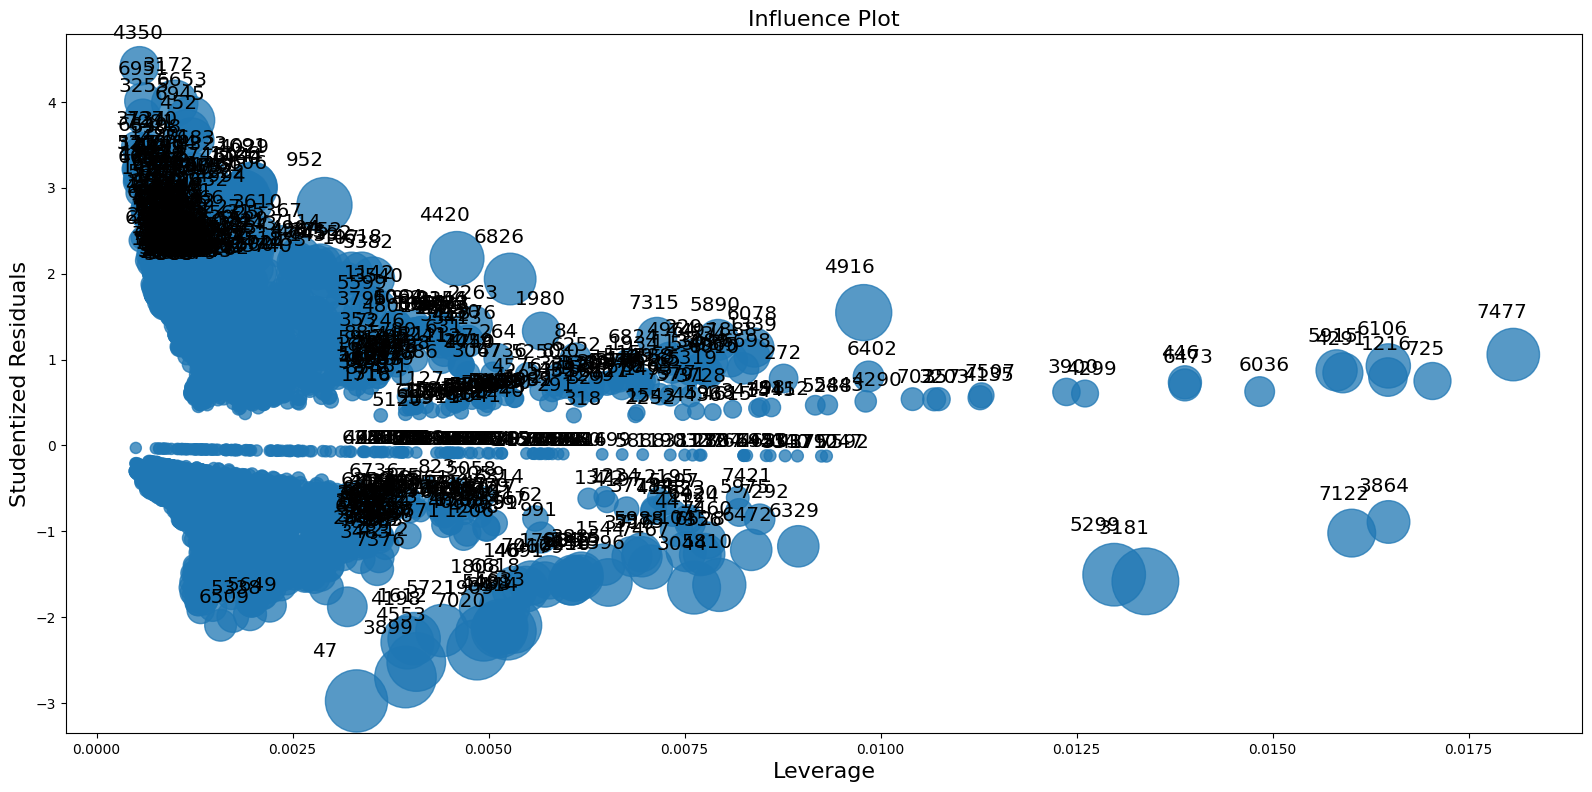

In [46]:
fig = infl.plot_influence()
fig.tight_layout(pad=1.0)

##### dfbetas признаков модели

[dfbetas](https://www.statsmodels.org/dev/generated/statsmodels.stats.outliers_influence.GLMInfluence.dfbetas.html) - масштабированное изменение оценок параметров.

Одношаговое изменение параметров масштабируется путем деления на стандартную ошибку оценки параметра

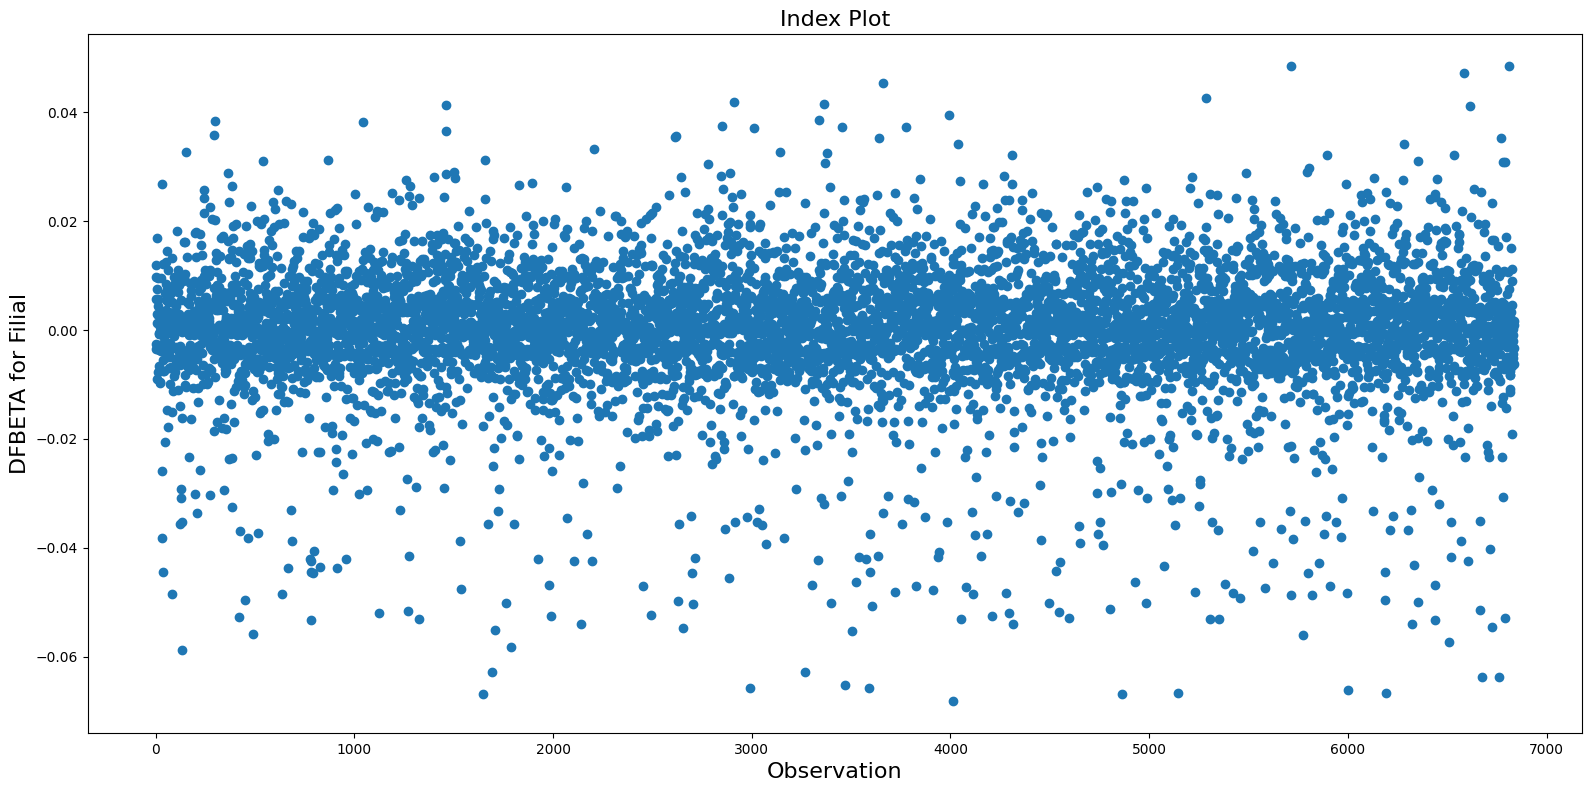

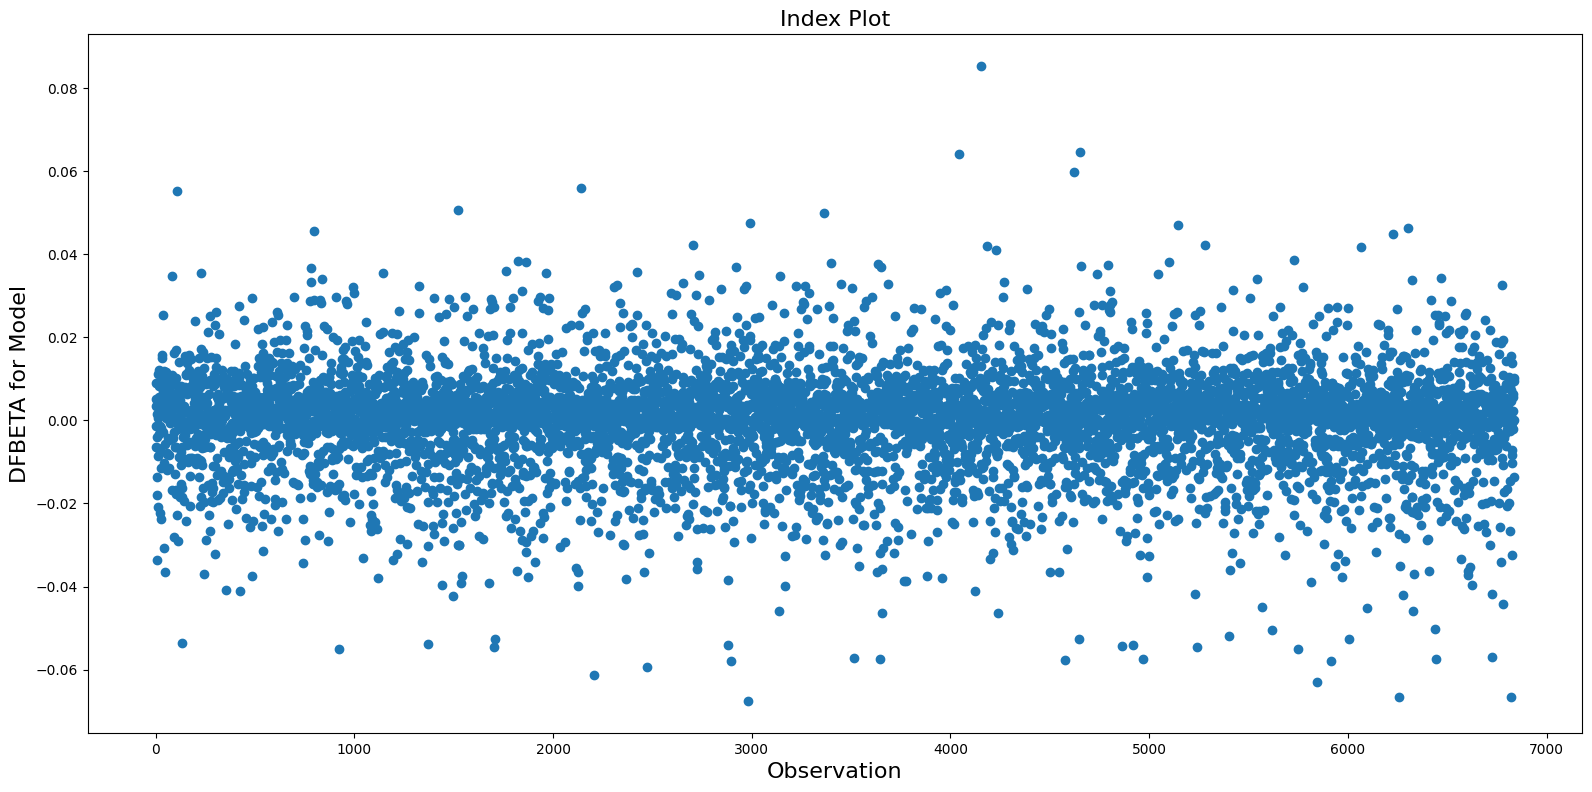

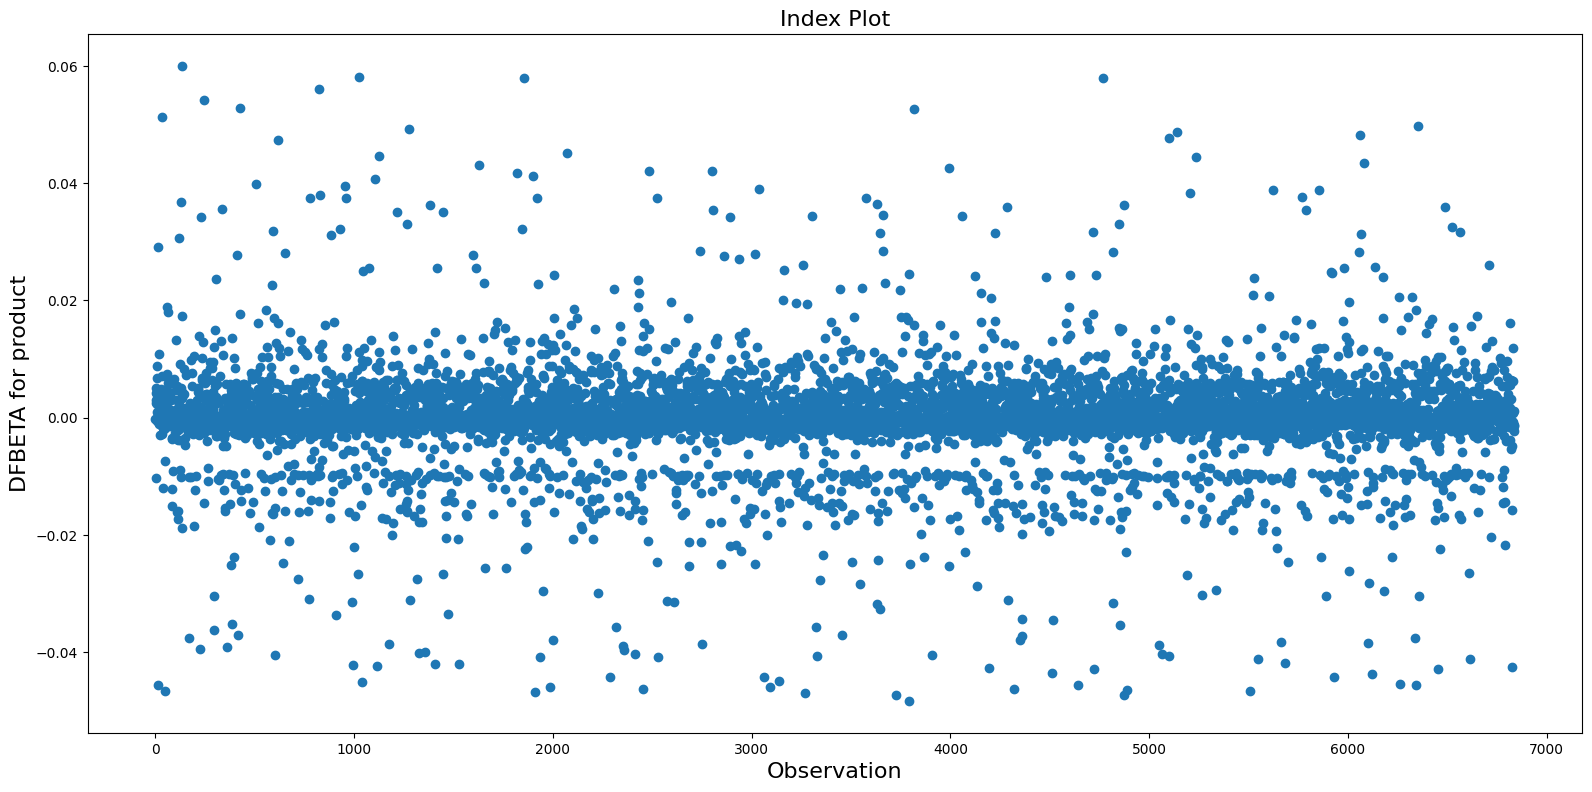

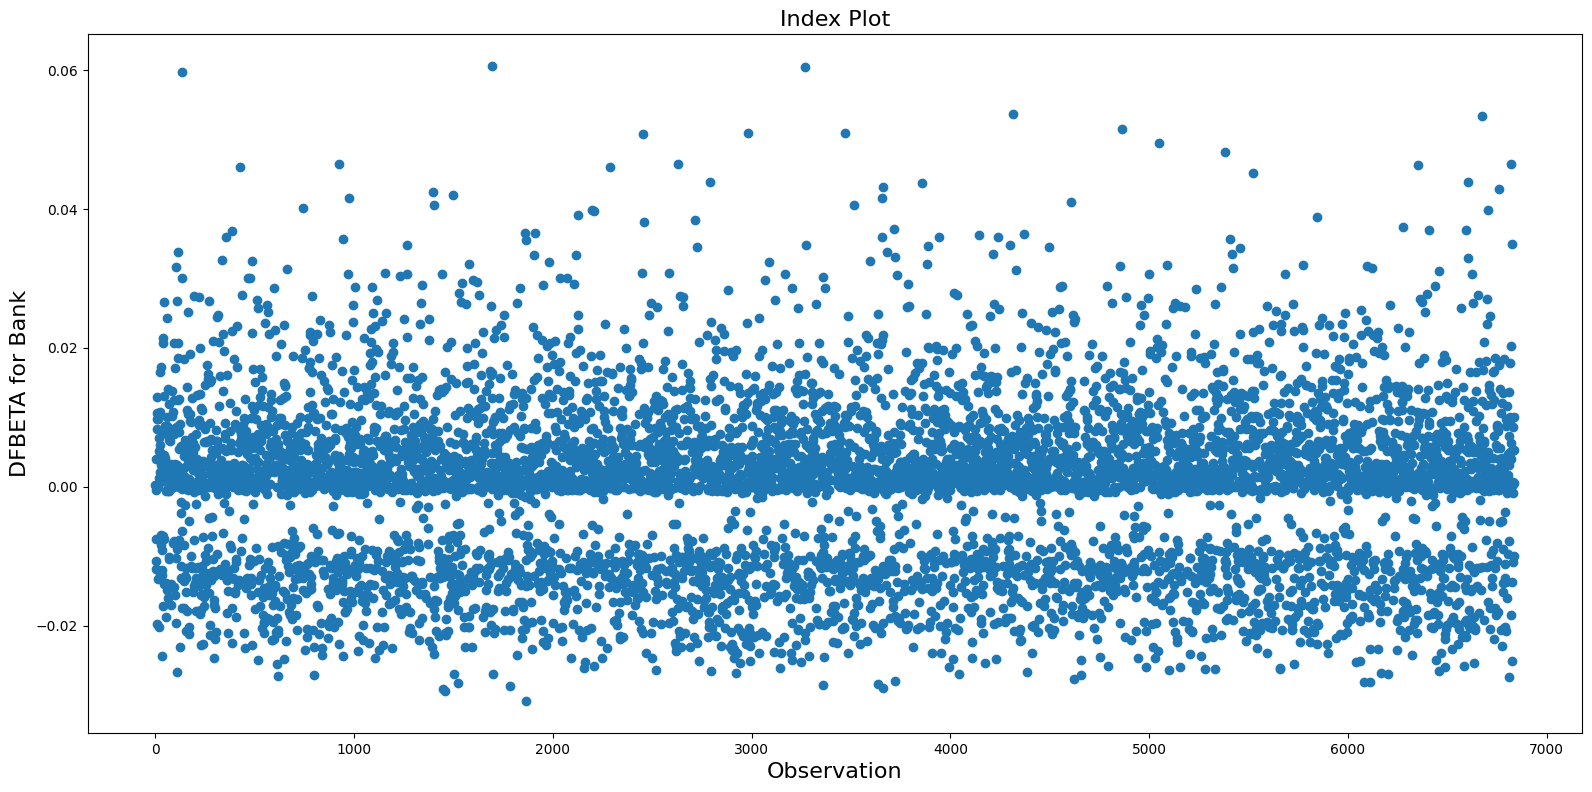

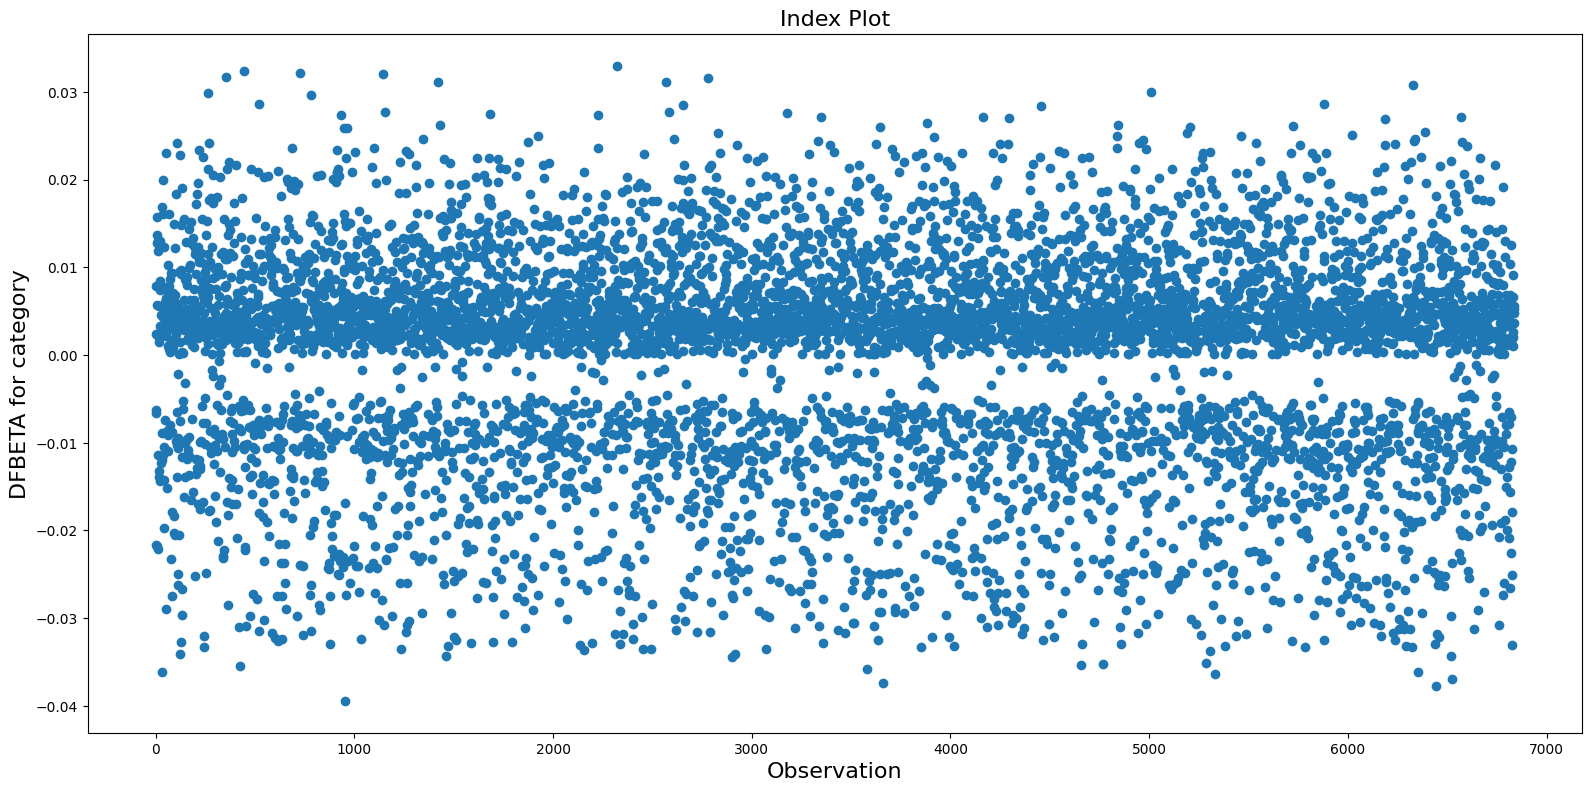

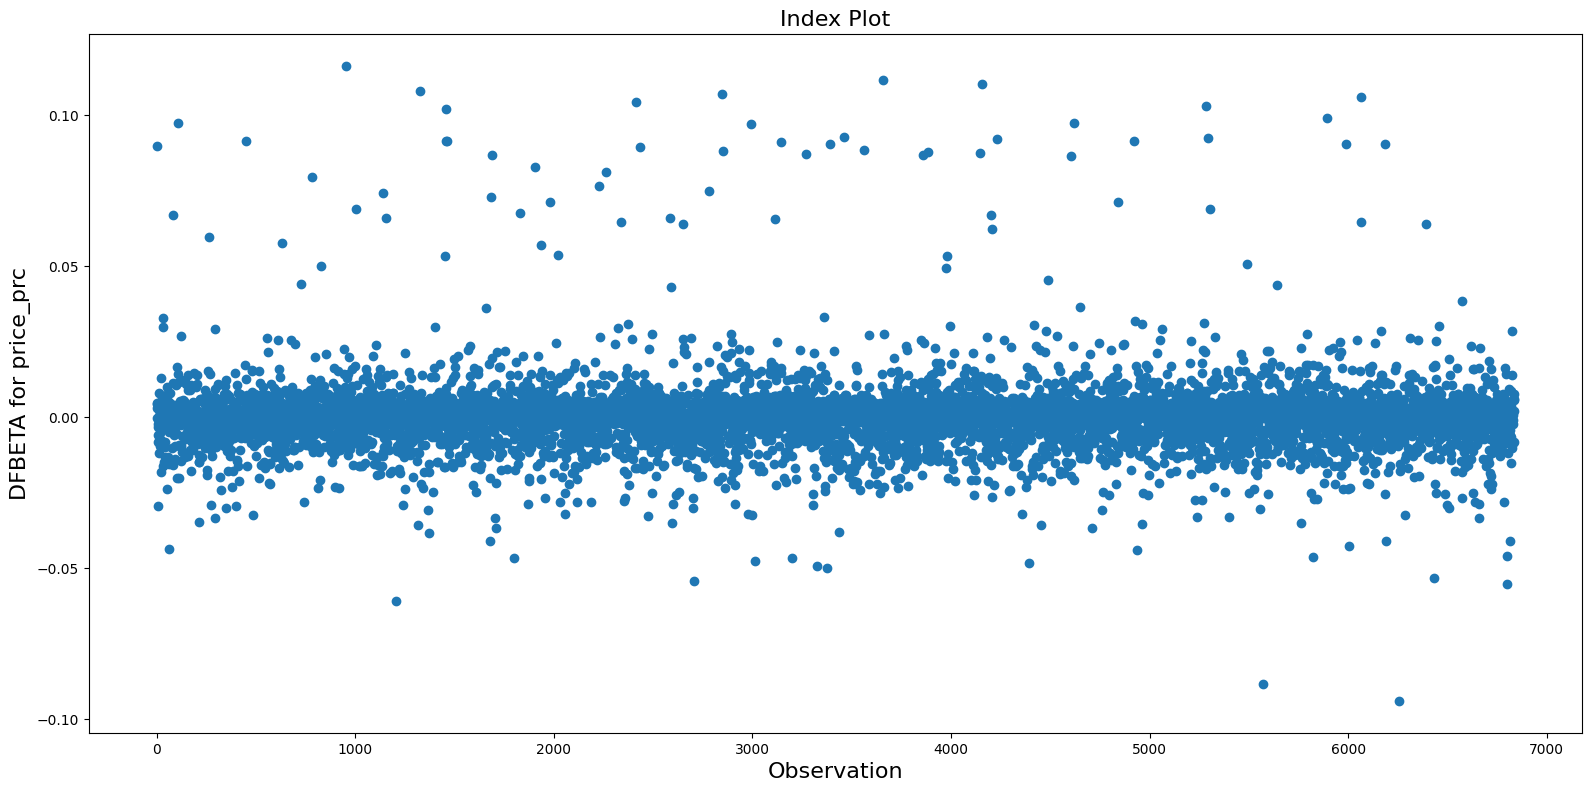

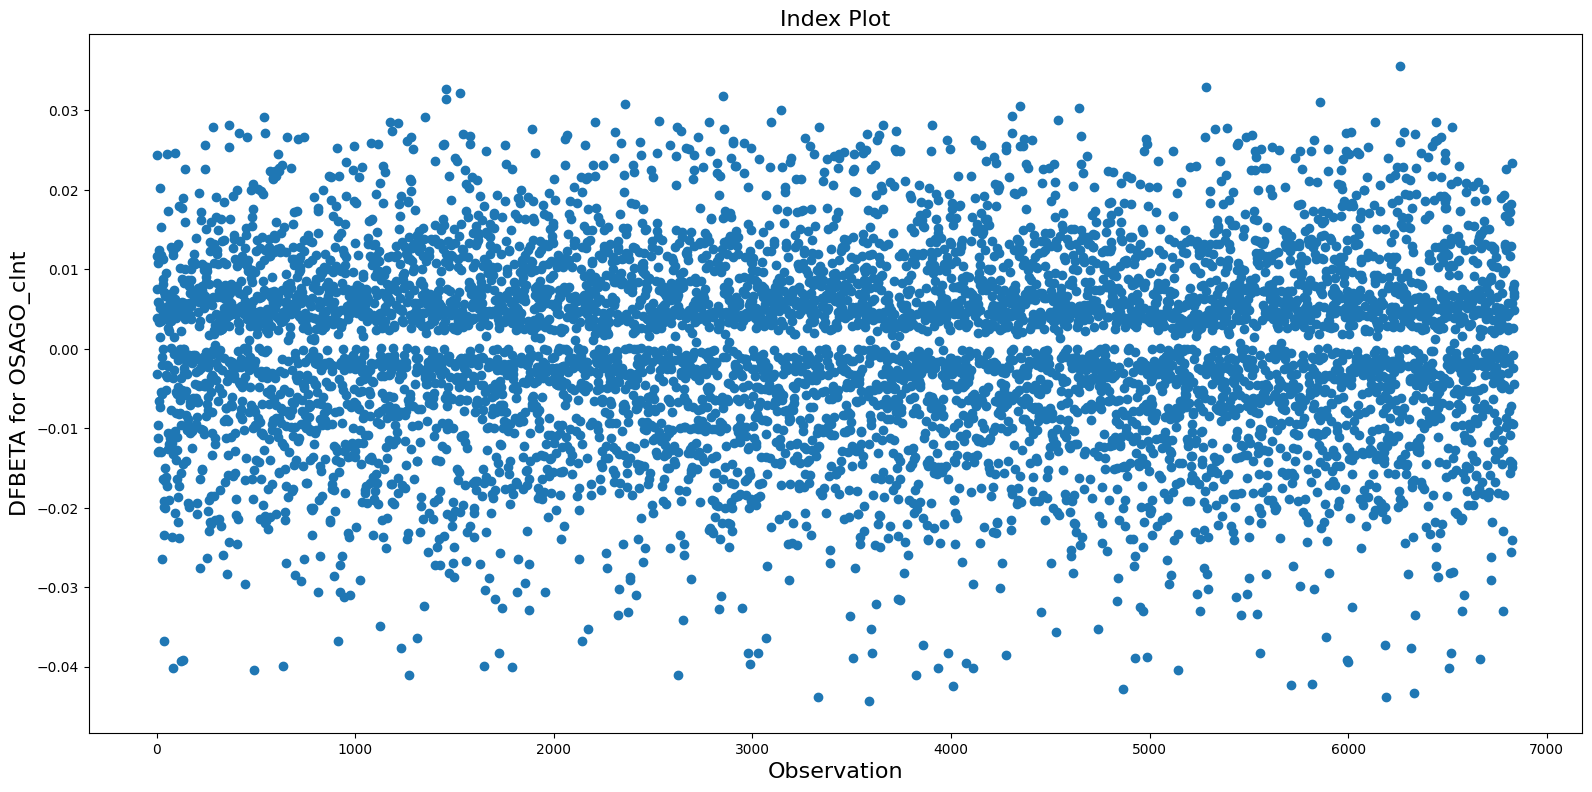

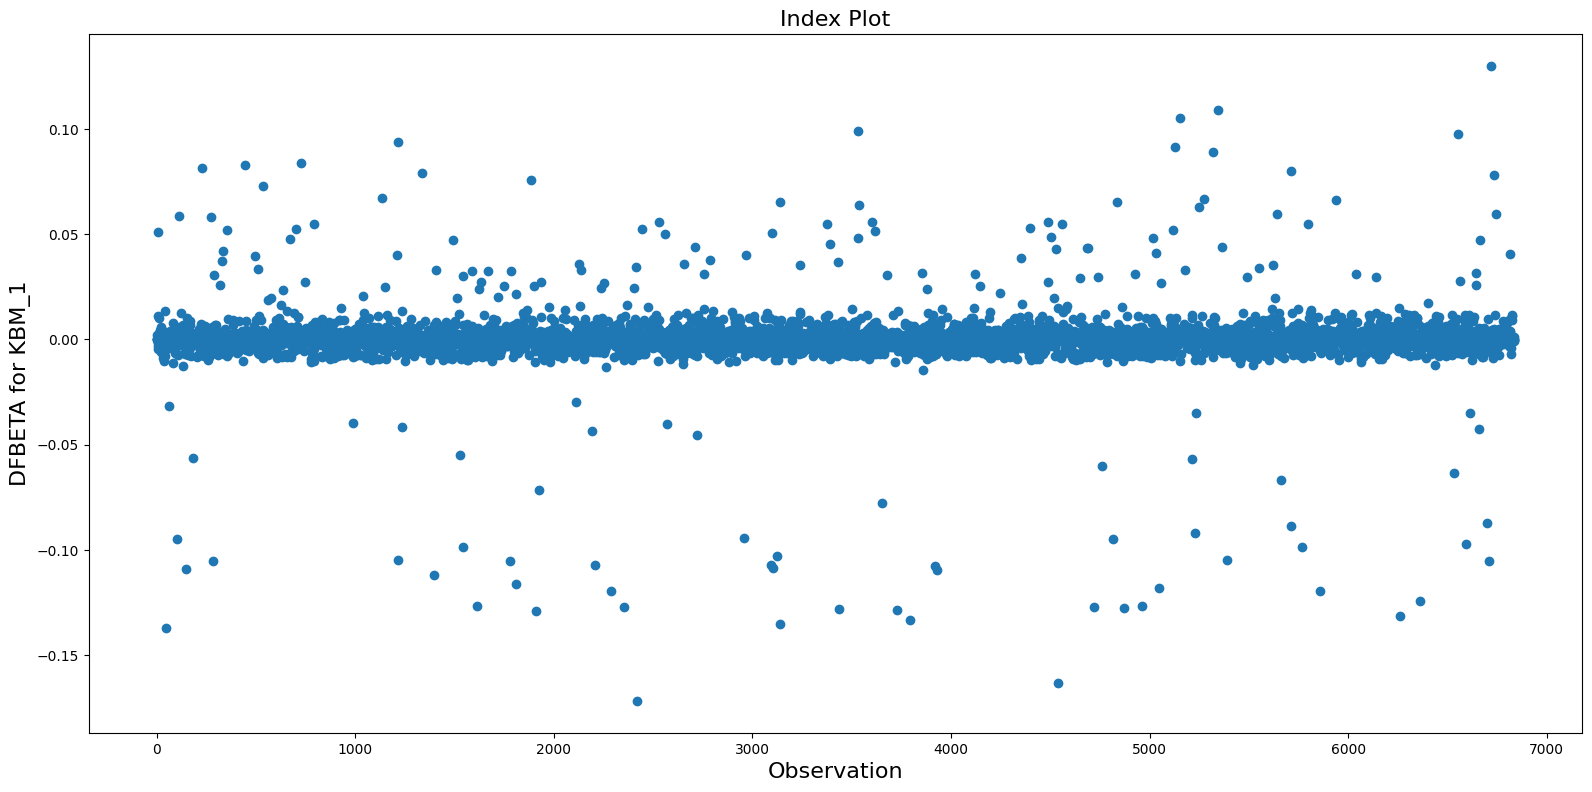

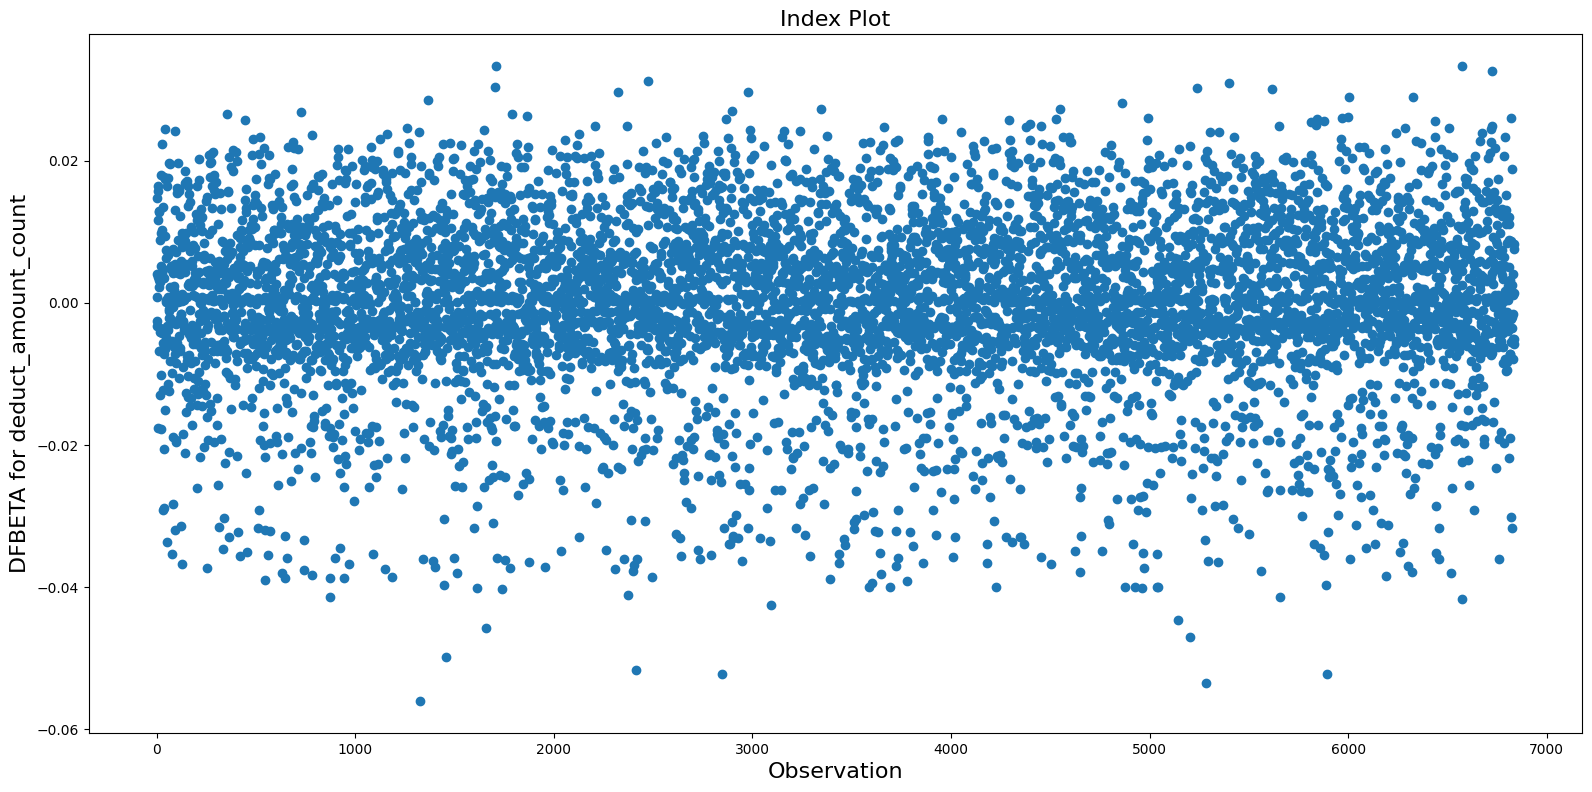

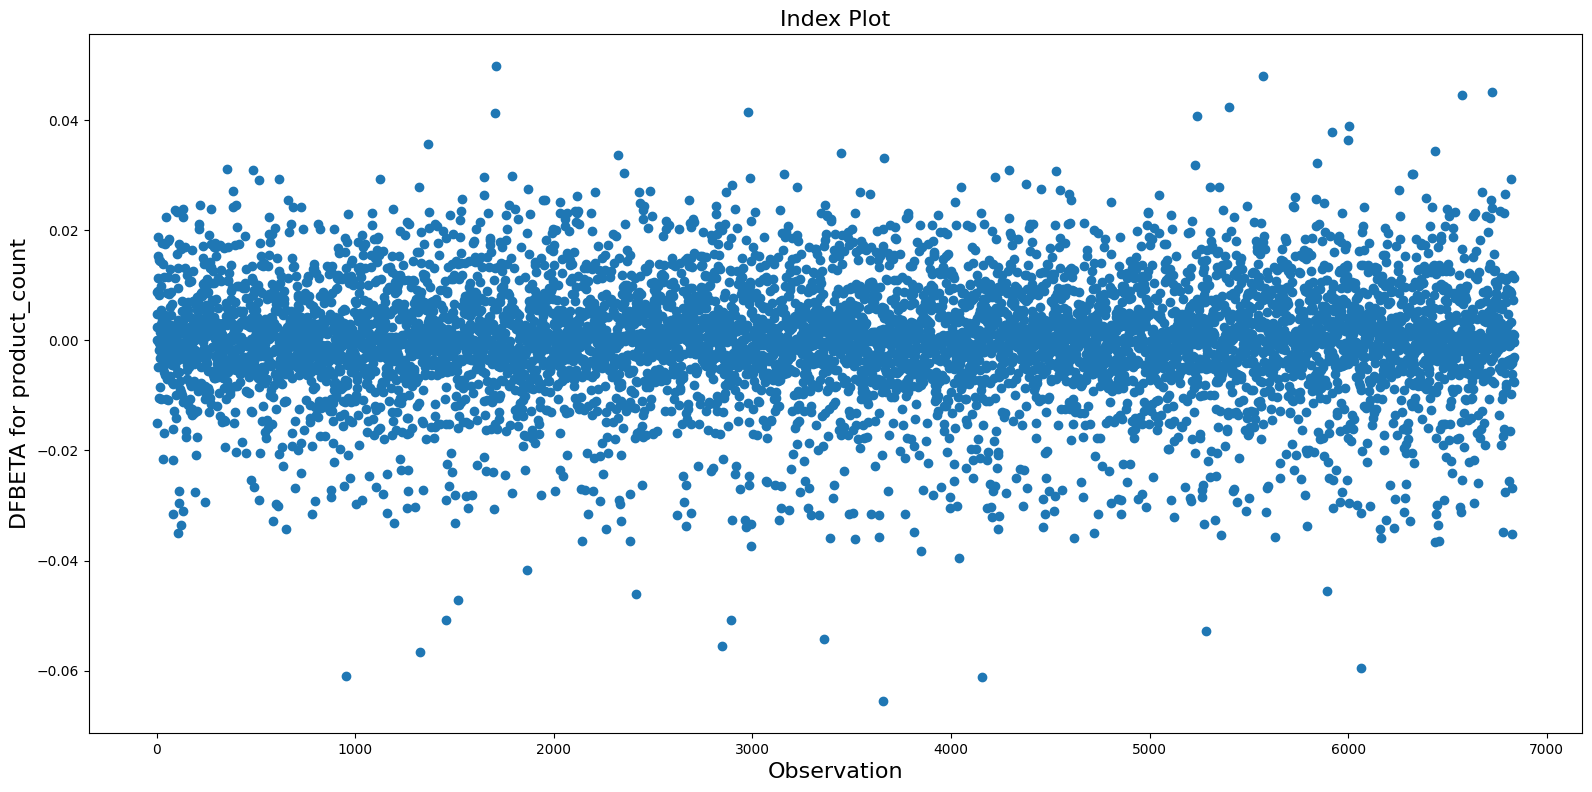

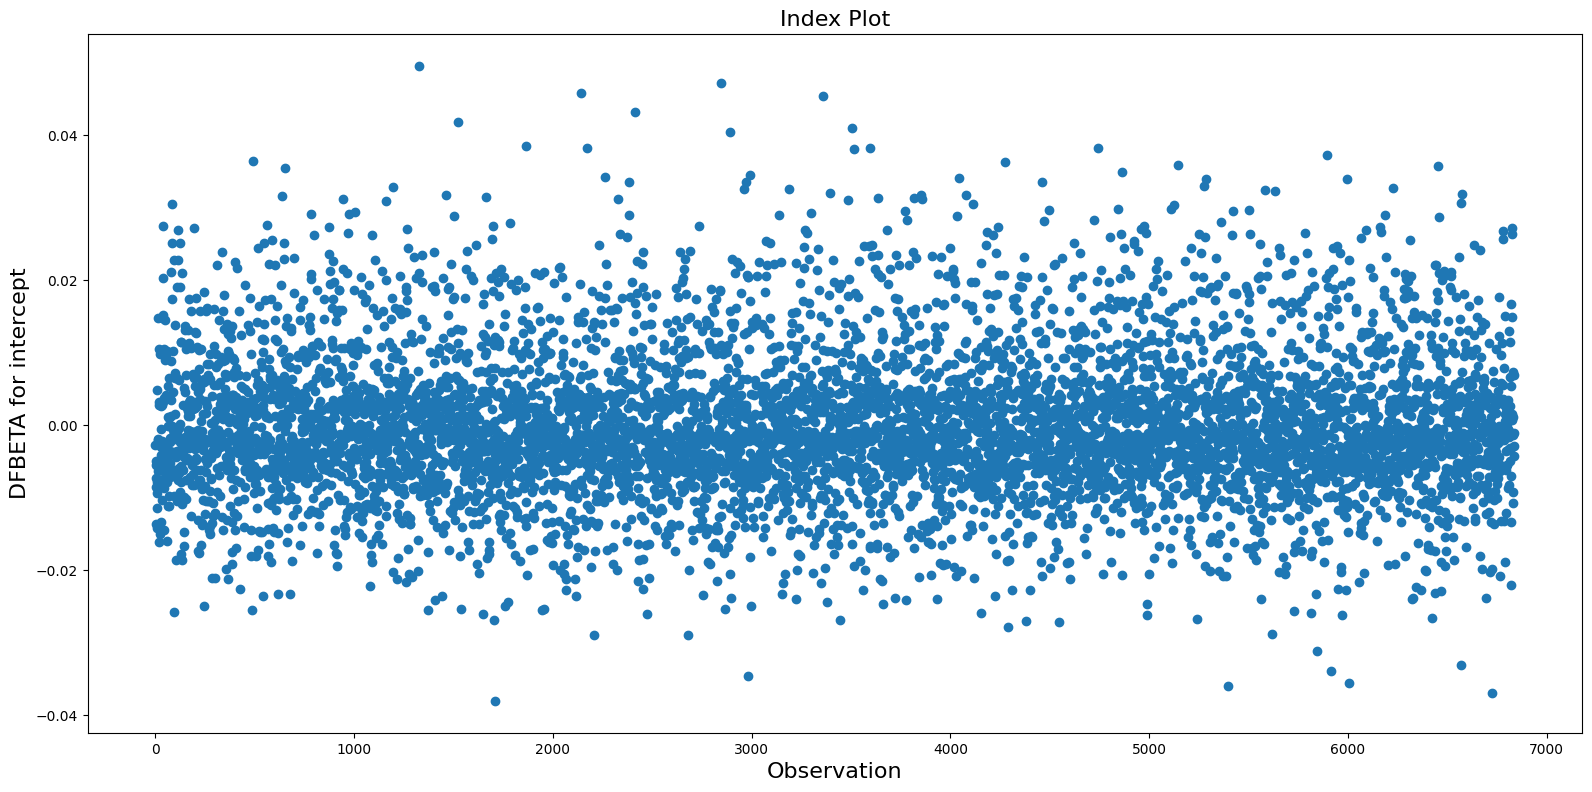

In [47]:
for i in range(len(features_GLM)):
  fig = infl.plot_index(y_var="dfbeta", idx=i, threshold=0.5)
  fig.tight_layout(pad=1.0)

#### 4.2.7. Сохранение модели

In [48]:
save = True
if save:
  file_name = f'model_GLM_auc_{str(max(aucs_glm))[2:6]}.joblib'
  model = models_glm[np.argmax(aucs_glm)]
  joblib.dump(model,  PATH + 'models/' + file_name)

  print(file_name)

model_GLM_auc_7772.joblib


In [49]:
selected_models.append(file_name)

### 4.3. GLM + Random Forest

In [50]:
def get_random_forest_results(idx_test, X_rf, y_rf, train, features_rf):
  rf = RandomForestRegressor(max_depth=6, random_state=25)
  rf.fit(X_rf, y_rf)
  y_pred_rf = rf.predict(train.loc[idx_test, features_rf])

  return y_pred_rf, rf

#### 4.3.1. Отбор признаков

In [51]:
n_splits = 10
cv = StratifiedKFold(n_splits=n_splits)
X = train[cols]
X['intercept'] = 1
y = train[TARGET_NAME]

aucs_glm_rf = []
selected = pd.DataFrame(index=cols)
for fold, (idx_train, idx_test) in enumerate(cv.split(X, y)):
    model = models_glm[fold]
    y_pred = model.predict(X.loc[idx_test, features_GLM])

    y_rf = y[idx_train] - model.predict(X.loc[idx_train, features_GLM])
    X_rf = train.loc[idx_train, cols]
    y_pred_rf, rf = get_random_forest_results(idx_test, X_rf, y_rf, train, cols)

    r = permutation_importance(rf, X_rf, y_rf, n_repeats=30, random_state=0)
    selected_rf = []
    for i in r.importances_mean.argsort()[::1]:
      if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        selected_rf.append(cols[i])
    selected.loc[:, f'{fold}'] = 0
    selected.loc[selected_rf, f'{fold}'] = 1

    y_pred += y_pred_rf
    aucs_glm_rf.append(roc_auc_score(y[idx_test], y_pred))

df_auc['GLM with RF'] = aucs_glm_rf

auc_mean = np.array(aucs_glm_rf).mean()
auc_std = np.array(aucs_glm_rf).std()
print(f'\nauc: {round(auc_mean, 4)} +/- {round(auc_std, 4)}')


auc: 0.7722 +/- 0.0156


In [52]:
selected[selected.mean(axis=1) < 1]

0  1  2  3  4  5  6  7  8  9
intercept  0  0  0  0  0  0  0  0  0  0

In [53]:
df_selected_features['GLM_rf'] = np.where(selected.mean(axis=1) == 1, 1, 0)

#### 4.3.2. Кросс-валидация

In [54]:
n_splits = 10
cv = StratifiedKFold(n_splits=n_splits)

X = train[cols]
y = train[TARGET_NAME]
features_rf = df_selected_features[df_selected_features['GLM_rf'] == 1].index.tolist()

models_glm_rf = []
aucs_glm_rf = []
for fold, (idx_train, idx_test) in enumerate(cv.split(X, y)):
    model = models_glm[fold]
    y_pred = model.predict(X.loc[idx_test, features_GLM])

    y_rf = y[idx_train] - model.predict(X.loc[idx_train, features_GLM])
    X_rf = train.loc[idx_train, features_rf]
    y_pred_rf, rf = get_random_forest_results(idx_test, X_rf, y_rf, train, features_rf)

    y_pred += y_pred_rf
    results.loc[idx_test, 'GLM RF'] = y_pred
    models_glm_rf.append(rf)
    aucs_glm_rf.append(roc_auc_score(y[idx_test], y_pred))

df_auc['GLM with RF'] = aucs_glm_rf

auc_mean = np.array(aucs_glm_rf).mean()
auc_std = np.array(aucs_glm_rf).std()
print(f'\nauc: {round(auc_mean, 4)} +/- {round(auc_std, 4)}')


auc: 0.7723 +/- 0.0156


#### 4.3.3. Area Under the Curve (AUC)

In [55]:
df_auc.round(4)

Logit     GLM  GLM with RF
0  0.7735  0.7773       0.7950
1  0.7616  0.7587       0.7883
2  0.7659  0.7680       0.7926
3  0.7747  0.7728       0.7866
4  0.7283  0.7320       0.7637
5  0.7277  0.7294       0.7552
6  0.7531  0.7526       0.7611
7  0.7629  0.7623       0.7676
8  0.7161  0.7227       0.7559
9  0.7204  0.7218       0.7565

In [56]:
df_auc.max().sort_values()

Logit          0.774689
GLM            0.777275
GLM with RF    0.795016
dtype: float64

#### 4.3.4. Random Forest feature importances

In [57]:
df = pd.DataFrame(
  index=models_glm_rf[np.argmax(aucs_glm_rf)].feature_names_in_.tolist(),
  columns=['importances']
)
df['importances'] = models_glm_rf[np.argmax(aucs_glm_rf)].feature_importances_
df.sort_values('importances', ascending=False)

importances
Yr_production            0.110716
Bank                     0.096704
Exp                      0.092660
Age                      0.083821
Model                    0.080954
Model_count              0.070658
Filial                   0.058099
Amount - gr              0.056285
price_gr_2               0.047732
Filial_count             0.044021
price_prc                0.029475
Brand                    0.027729
discount                 0.025141
price_gr_1               0.019154
VIP_count                0.016612
category                 0.015235
channel - map_count      0.014706
sex_mariage              0.013584
deduct_amount_count      0.011343
delta_kbm                0.011271
category_count           0.010323
GAP_count                0.009898
product_count            0.009398
OSAGO_clnt               0.008798
product                  0.006786
kvs_type_count           0.005650
sex_count                0.004497
price_gr_3               0.003859
diff_passport_region     0.003668
KBM_1                    0.003458
Type_ts_count            0.002829
Bank_count               0.002692
premium_car              0.002243

#### 4.3.5. Сохранение модели

In [58]:
save = True
if save:
  file_name = f'model_GLM_rf_auc_{str(max(aucs_glm_rf))[2:6]}.joblib'
  model = models_glm_rf[np.argmax(aucs_glm_rf)]
  joblib.dump(model,  PATH + 'models/' + file_name)

  print(file_name)

model_GLM_rf_auc_7950.joblib


In [59]:
selected_models.append(file_name)

### 4.4. GLM + LightGBM

In [60]:
def get_boosting_results(
    idx_train, idx_test, linear_model, train, features_linear, features_lgb
):
  params_lgb = {
      'task': 'train',
      'boosting': 'gbdt',
      'objective': 'regression',
      'num_leaves': 20,
      'learnnig_rage': 0.00001,
      'metric': 'mse',
      'early_stopping_rounds': 30,
      'random_seed': 25,
      'verbose': -1
  }
  n = int(len(idx_train) * 0.85)
  idx_train_lgb = np.random.choice(idx_train, n, replace=False)
  idx_valid_lgb  = list(set(idx_train) - set(idx_train_lgb))

  X_train_lgb = train.loc[idx_train_lgb, features_lgb]
  y_train_lgb = y[idx_train_lgb] - linear_model.predict(X.loc[idx_train_lgb, features_linear])
  X_valid_lgb = train.loc[idx_valid_lgb, features_lgb]
  y_valid_lgb = y[idx_valid_lgb] - linear_model.predict(X.loc[idx_valid_lgb, features_linear])

  dtrain = lgb.Dataset(X_train_lgb, y_train_lgb)
  dvalid = lgb.Dataset(X_valid_lgb, y_valid_lgb, reference=dtrain)

  model_lgb = lgb.train(
      params_lgb,
      train_set=dtrain,
      valid_sets=dvalid,
  )
  y_pred_lgb = model_lgb.predict(train.loc[idx_test, features_lgb])

  return y_pred_lgb, model_lgb

#### 4.4.1. Отбор признаков

In [61]:
np.random.seed(42)

n_splits = 10
cv = StratifiedKFold(n_splits=n_splits)
X = train[cols]
y = train[TARGET_NAME]

aucs_glm_lgb = []
selected = pd.DataFrame(index=cols)
for fold, (idx_train, idx_test) in enumerate(cv.split(X, y)):
    model = models_glm[fold]
    y_pred = model.predict(X.loc[idx_test, features_GLM])
    y_pred_lgb, model_lgb = get_boosting_results(
        idx_train, idx_test, model, train, features_GLM, cols
    )
    explainer = shap.TreeExplainer(model_lgb)
    shap_values = explainer.shap_values(train.loc[idx_test, cols])

    selected.loc[:, f'{fold}'] = np.where(abs(shap_values.mean(axis=0)) > 0, 1, 0)

    y_pred += y_pred_lgb
    aucs_glm_lgb.append(roc_auc_score(y[idx_test], y_pred))

df_auc['GLM with LGB'] = aucs_glm_lgb

auc_mean = np.array(aucs_glm_lgb).mean()
auc_std = np.array(aucs_glm_lgb).std()
print(f'auc: {round(auc_mean, 4)} +/- {round(auc_std, 4)}')

auc: 0.7688 +/- 0.0182


In [62]:
selected[selected.mean(axis=1) < 0.7]

0  1  2  3  4  5  6  7  8  9
premium_car           0  0  1  0  0  1  1  0  0  0
KBM_1                 0  0  1  0  1  1  1  0  0  0
diff_passport_region  1  1  0  1  0  1  1  1  0  0
Bank_count            0  1  1  0  1  1  1  0  0  1
kvs_type_count        0  0  1  0  1  1  1  0  0  1
intercept             0  0  0  0  0  0  0  0  0  0

In [63]:
df_selected_features['GLM_lgb'] = np.where(selected.mean(axis=1) >= 0.7, 1, 0)

#### 4.4.2. Кросс-валидация

In [64]:
np.random.seed(42)

n_splits = 10
cv = StratifiedKFold(n_splits=n_splits)
X = train[cols]
X['intercept'] = 1
y = train[TARGET_NAME]
features_lgb = df_selected_features[df_selected_features['GLM_lgb'] == 1].index.tolist()

models_glm_lgb = []
aucs_glm_lgb = []
for fold, (idx_train, idx_test) in enumerate(cv.split(X, y)):
    model = models_glm[fold]
    y_pred = model.predict(X.loc[idx_test, features_GLM])
    y_pred_lgb, model_lgb = get_boosting_results(
        idx_train, idx_test, model, train, features_GLM, features_lgb
    )
    y_pred += y_pred_lgb
    results.loc[idx_test, 'GLM LGB'] = y_pred
    models_glm_lgb.append(model_lgb)
    aucs_glm_lgb.append(roc_auc_score(y[idx_test], y_pred))

df_auc['GLM with LGB'] = aucs_glm_lgb

auc_mean = np.array(aucs_glm_lgb).mean()
auc_std = np.array(aucs_glm_lgb).std()
print(f'auc: {round(auc_mean, 4)} +/- {round(auc_std, 4)}')

auc: 0.7691 +/- 0.0165


#### 4.4.3. Area Under the Curve (AUC)

In [65]:
df_auc.round(4)

Logit     GLM  GLM with RF  GLM with LGB
0  0.7735  0.7773       0.7950        0.7914
1  0.7616  0.7587       0.7883        0.7825
2  0.7659  0.7680       0.7926        0.7907
3  0.7747  0.7728       0.7866        0.7891
4  0.7283  0.7320       0.7637        0.7541
5  0.7277  0.7294       0.7552        0.7525
6  0.7531  0.7526       0.7611        0.7605
7  0.7629  0.7623       0.7676        0.7671
8  0.7161  0.7227       0.7559        0.7508
9  0.7204  0.7218       0.7565        0.7527

In [66]:
df_auc.max().sort_values()

Logit           0.774689
GLM             0.777275
GLM with LGB    0.791377
GLM with RF     0.795016
dtype: float64

#### 4.4.4. LightGBM feature importances

In [67]:
df_lgb = pd.DataFrame(
    index=models_glm_lgb[np.argmax(aucs_glm_lgb)].feature_name(),
    columns=['importances']
)
df_lgb['importances'] = models_glm_lgb[np.argmax(aucs_glm_lgb)].feature_importance()
df_lgb.sort_values('importances', ascending=False)

importances
Exp                           50
Age                           44
Model                         35
Yr_production                 35
Model_count                   27
Amount_-_gr                   25
Filial                        24
Filial_count                  22
Bank                          19
price_gr_2                    19
Brand                         18
category                      14
VIP_count                     11
discount                      11
price_gr_1                    10
price_prc                      9
sex_mariage                    7
delta_kbm                      6
channel_-_map_count            6
product_count                  5
price_gr_3                     4
deduct_amount_count            4
OSAGO_clnt                     3
product                        3
sex_count                      3
category_count                 2
Type_ts_count                  1
GAP_count                      1

#### 4.4.5. Сохранение модели

In [68]:
save = True
if save:
  file_name = f'model_GLM_lgb_auc_{str(max(aucs_glm_lgb))[2:6]}.joblib'
  model = models_glm_lgb[np.argmax(aucs_glm_lgb)]
  joblib.dump(model,  PATH + 'models/' + file_name)

  print(file_name)

model_GLM_lgb_auc_7913.joblib


In [69]:
selected_models.append(file_name)

### 4.5. Logit + Random Forest

#### 4.5.1. Отбор признаков Logit + Random Forest

In [70]:
n_splits = 10
cv = StratifiedKFold(n_splits=n_splits)
X = train[cols]
y = train[TARGET_NAME]

aucs_logit_rf = []
selected = pd.DataFrame(index=cols)
for fold, (idx_train, idx_test) in enumerate(cv.split(X, y)):
    model = models_logit[fold]
    y_pred = model.predict(X.loc[idx_test, features_logit])

    y_rf = y[idx_train] - model.predict(X.loc[idx_train, features_logit])
    X_rf = train.loc[idx_train, cols]
    y_pred_rf, rf = get_random_forest_results(idx_test, X_rf, y_rf, train, cols)

    r = permutation_importance(rf, X_rf, y_rf, n_repeats=30, random_state=0)
    selected_rf = []
    for i in r.importances_mean.argsort()[::1]:
      if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        selected_rf.append(cols[i])
    selected.loc[:, f'{fold}'] = 0
    selected.loc[selected_rf, f'{fold}'] = 1

    y_pred += y_pred_rf
    aucs_logit_rf.append(roc_auc_score(y[idx_test], y_pred))

auc_mean = np.array(aucs_logit_rf).mean()
auc_std = np.array(aucs_logit_rf).std()
print(f'\nauc: {round(auc_mean, 4)} +/- {round(auc_std, 4)}')


auc: 0.7702 +/- 0.0158


In [71]:
selected[selected.mean(axis=1) < 1]

0  1  2  3  4  5  6  7  8  9
intercept  0  0  0  0  0  0  0  0  0  0

In [72]:
df_selected_features['Logit_rf'] = np.where(selected.mean(axis=1) == 1, 1, 0)

#### 4.5.2. Кросс-валидация

In [73]:
n_splits = 10
cv = StratifiedKFold(n_splits=n_splits)

X = train[cols]
y = train[TARGET_NAME]
features_rf = df_selected_features[df_selected_features['Logit_rf'] == 1].index.tolist()

models_logit_rf = []
aucs_logit_rf = []
for fold, (idx_train, idx_test) in enumerate(cv.split(X, y)):
    model = models_logit[fold]
    y_pred = model.predict(X.loc[idx_test, features_logit])

    y_rf = y[idx_train] - model.predict(X.loc[idx_train, features_logit])
    X_rf = train.loc[idx_train, features_rf]
    y_pred_logit_rf, rf = get_random_forest_results(
        idx_test, X_rf, y_rf, train, features_rf
    )
    y_pred += y_pred_logit_rf
    results.loc[idx_test, 'Logit RF'] = y_pred
    models_logit_rf.append(rf)
    aucs_logit_rf.append(roc_auc_score(y[idx_test], y_pred))

df_auc['Logit with RF'] = aucs_logit_rf

auc_mean = np.array(aucs_logit_rf).mean()
auc_std = np.array(aucs_logit_rf).std()
print(f'\nauc: {round(auc_mean, 4)} +/- {round(auc_std, 4)}')


auc: 0.7703 +/- 0.0159


#### 4.5.3. Area Under the Curve (AUC)

In [74]:
df_auc.round(4)

Logit     GLM  GLM with RF  GLM with LGB  Logit with RF
0  0.7735  0.7773       0.7950        0.7914         0.7913
1  0.7616  0.7587       0.7883        0.7825         0.7891
2  0.7659  0.7680       0.7926        0.7907         0.7893
3  0.7747  0.7728       0.7866        0.7891         0.7859
4  0.7283  0.7320       0.7637        0.7541         0.7591
5  0.7277  0.7294       0.7552        0.7525         0.7535
6  0.7531  0.7526       0.7611        0.7605         0.7610
7  0.7629  0.7623       0.7676        0.7671         0.7680
8  0.7161  0.7227       0.7559        0.7508         0.7520
9  0.7204  0.7218       0.7565        0.7527         0.7535

In [75]:
df_auc.max().sort_values()

Logit            0.774689
GLM              0.777275
Logit with RF    0.791305
GLM with LGB     0.791377
GLM with RF      0.795016
dtype: float64

#### 4.5.4. Random Forest feature importances

In [76]:
df = pd.DataFrame(
    index=models_logit_rf[np.argmax(aucs_logit_rf)].feature_names_in_.tolist(), columns=['importances']
)
df['importances'] = models_logit_rf[np.argmax(aucs_logit_rf)].feature_importances_
df.sort_values('importances', ascending=False)

importances
Yr_production            0.100057
Bank                     0.099905
Exp                      0.088900
Model                    0.081231
Age                      0.079078
Model_count              0.068578
Amount - gr              0.058026
Filial                   0.055736
Filial_count             0.044164
price_gr_2               0.041642
Brand                    0.028359
price_prc                0.026175
price_gr_1               0.024789
discount                 0.023371
product_count            0.021956
VIP_count                0.017522
KBM_1                    0.015309
channel - map_count      0.013305
sex_mariage              0.012668
deduct_amount_count      0.011292
category                 0.010894
delta_kbm                0.010448
product                  0.010318
category_count           0.008553
OSAGO_clnt               0.008544
GAP_count                0.008365
price_gr_3               0.006724
kvs_type_count           0.006625
sex_count                0.004895
Bank_count               0.003912
diff_passport_region     0.003445
premium_car              0.003102
Type_ts_count            0.002112

#### 4.5.5. Сохранение модели

In [77]:
save = True
if save:
  file_name = f'model_Logit_rf_auc_{str(max(aucs_logit_rf))[2:6]}.joblib'
  model = models_logit_rf[np.argmax(aucs_logit_rf)]
  joblib.dump(model,  PATH + 'models/' + file_name)

  print(file_name)

model_Logit_rf_auc_7913.joblib


In [78]:
selected_models.append(file_name)

### 4.6. Logit + LightGBM

#### 4.6.1. Отбор признаков

In [79]:
np.random.seed(9)

n_splits = 10
cv = StratifiedKFold(n_splits=n_splits)
X = train[cols]
y = train[TARGET_NAME]

aucs_logit_lgb = []
selected = pd.DataFrame(index=cols)
for fold, (idx_train, idx_test) in enumerate(cv.split(X, y)):
    model = models_logit[fold]
    y_pred = model.predict(X.loc[idx_test, features_logit])

    y_pred_lgb, model_lgb = get_boosting_results(
        idx_train, idx_test, model, train, features_logit, cols
    )
    explainer = shap.TreeExplainer(model_lgb)
    shap_values = explainer.shap_values(train.loc[idx_test, cols])
    selected.loc[:, f'{fold}'] = np.where(abs(shap_values.mean(axis=0)) > 0, 1, 0)

    y_pred += y_pred_lgb
    aucs_logit_lgb.append(roc_auc_score(y[idx_test], y_pred))

auc_mean = np.array(aucs_logit_lgb).mean()
auc_std = np.array(aucs_logit_lgb).std()
print(f'auc: {round(auc_mean, 4)} +/- {round(auc_std, 4)}')

auc: 0.7692 +/- 0.0175


In [80]:
selected[selected.mean(axis=1) == 1]

0  1  2  3  4  5  6  7  8  9
Filial               1  1  1  1  1  1  1  1  1  1
Brand                1  1  1  1  1  1  1  1  1  1
Model                1  1  1  1  1  1  1  1  1  1
Yr_production        1  1  1  1  1  1  1  1  1  1
product              1  1  1  1  1  1  1  1  1  1
Bank                 1  1  1  1  1  1  1  1  1  1
category             1  1  1  1  1  1  1  1  1  1
Age                  1  1  1  1  1  1  1  1  1  1
Exp                  1  1  1  1  1  1  1  1  1  1
discount             1  1  1  1  1  1  1  1  1  1
Amount - gr          1  1  1  1  1  1  1  1  1  1
price_prc            1  1  1  1  1  1  1  1  1  1
KBM_1                1  1  1  1  1  1  1  1  1  1
price_gr_1           1  1  1  1  1  1  1  1  1  1
price_gr_2           1  1  1  1  1  1  1  1  1  1
sex_mariage          1  1  1  1  1  1  1  1  1  1
Filial_count         1  1  1  1  1  1  1  1  1  1
VIP_count            1  1  1  1  1  1  1  1  1  1
Model_count          1  1  1  1  1  1  1  1  1  1
GAP_count            1  1  1  1  1  1  1  1  1  1
deduct_amount_count  1  1  1  1  1  1  1  1  1  1
product_count        1  1  1  1  1  1  1  1  1  1
channel - map_count  1  1  1  1  1  1  1  1  1  1

In [81]:
df_selected_features['Logit_lgb'] = np.where(selected.mean(axis=1) == 1, 1, 0)

#### 4.6.2. Кросс-валидация

In [82]:
np.random.seed(9)

n_splits = 10
cv = StratifiedKFold(n_splits=n_splits)
X = train[cols]
y = train[TARGET_NAME]
features_lgb = df_selected_features[df_selected_features['Logit_lgb'] == 1].index.tolist()

models_logit_lgb = []
aucs_logit_lgb = []
for fold, (idx_train, idx_test) in enumerate(cv.split(X, y)):
    model = models_logit[fold]
    y_pred = model.predict(X.loc[idx_test, features_logit])
    y_pred_logit_lgb, model_lgb = get_boosting_results(
        idx_train, idx_test, model, train, features_logit, features_lgb
    )
    y_pred += y_pred_logit_lgb
    results.loc[idx_test, 'Logit LGB'] = y_pred
    models_logit_lgb.append(model_lgb)
    aucs_logit_lgb.append(roc_auc_score(y[idx_test], y_pred))

df_auc['Logit with LGB'] = aucs_logit_lgb

auc_mean = np.array(aucs_logit_lgb).mean()
auc_std = np.array(aucs_logit_lgb).std()
print(f'auc: {round(auc_mean, 4)} +/- {round(auc_std, 4)}')

auc: 0.7706 +/- 0.0171


#### 4.6.3. Area Under the Curve (AUC)

In [83]:
df_auc.round(4)

Logit     GLM  GLM with RF  GLM with LGB  Logit with RF  Logit with LGB
0  0.7735  0.7773       0.7950        0.7914         0.7913          0.7935
1  0.7616  0.7587       0.7883        0.7825         0.7891          0.7907
2  0.7659  0.7680       0.7926        0.7907         0.7893          0.7853
3  0.7747  0.7728       0.7866        0.7891         0.7859          0.7840
4  0.7283  0.7320       0.7637        0.7541         0.7591          0.7641
5  0.7277  0.7294       0.7552        0.7525         0.7535          0.7549
6  0.7531  0.7526       0.7611        0.7605         0.7610          0.7647
7  0.7629  0.7623       0.7676        0.7671         0.7680          0.7772
8  0.7161  0.7227       0.7559        0.7508         0.7520          0.7460
9  0.7204  0.7218       0.7565        0.7527         0.7535          0.7454

In [84]:
df_auc.max().sort_values()

Logit             0.774689
GLM               0.777275
Logit with RF     0.791305
GLM with LGB      0.791377
Logit with LGB    0.793511
GLM with RF       0.795016
dtype: float64

#### 4.6.4. LightGBM feature importances

In [85]:
df_logit_lgb = pd.DataFrame(
    index=models_logit_lgb[np.argmax(aucs_logit_lgb)].feature_name(),
    columns=['importances']
)
df_logit_lgb['importances'] = models_logit_lgb[np.argmax(aucs_logit_lgb)].feature_importance()
df_logit_lgb.sort_values('importances', ascending=False)

importances
Exp                           56
Age                           49
Model_count                   38
Model                         34
Filial                        33
Yr_production                 32
Filial_count                  24
Amount_-_gr                   22
price_gr_2                    22
Brand                         21
channel_-_map_count           20
category                      20
Bank                          17
discount                      12
KBM_1                         10
product_count                 10
price_prc                     10
deduct_amount_count            6
price_gr_1                     5
VIP_count                      5
product                        5
sex_mariage                    4
GAP_count                      1

#### 4.6.5. Сохранение модели

In [86]:
save = True
if save:
  file_name = f'model_Logit_lgb_auc_{str(max(aucs_logit_lgb))[2:6]}.joblib'
  model = models_logit_lgb[np.argmax(aucs_logit_lgb)]
  joblib.dump(model,  PATH + 'models/' + file_name)

  print(file_name)

model_Logit_lgb_auc_7935.joblib


In [87]:
selected_models.append(file_name)

### 4.7. Сравнение моделей

In [88]:
df = pd.concat([df_aic.mean(), df_aic.std()], axis=1)
df.columns = ['AIC mean', 'AIC std']
df.round(1)

AIC mean  AIC std
Logit    7298.0     25.3
GLM      7274.6     23.8

In [89]:
df = pd.concat([df_auc.mean(), df_auc.std()], axis=1)
df.columns = ['AUC mean', 'AUC std']
df.round(4)

AUC mean  AUC std
Logit             0.7484   0.0228
GLM               0.7498   0.0214
GLM with RF       0.7723   0.0164
GLM with LGB      0.7691   0.0174
Logit with RF     0.7703   0.0167
Logit with LGB    0.7706   0.0181

* Stacking будем делать на 4 моделях с AUC выше 0.76

In [90]:
df_selected_features

Logit  GLM  GLM_rf  GLM_lgb  Logit_rf  Logit_lgb
Filial                    1    1       1        1         1          1
Brand                     0    0       1        1         1          1
Model                     1    1       1        1         1          1
Yr_production             0    0       1        1         1          1
delta_kbm                 0    0       1        1         1          0
product                   1    1       1        1         1          1
Bank                      1    1       1        1         1          1
category                  1    1       1        1         1          1
Age                       0    0       1        1         1          1
Exp                       0    0       1        1         1          1
discount                  0    0       1        1         1          1
Amount - gr               0    0       1        1         1          1
premium_car               0    0       1        0         1          0
price_prc                 1    1       1        1         1          1
OSAGO_clnt                1    1       1        1         1          0
KBM_1                     0    1       1        0         1          1
price_gr_1                0    0       1        1         1          1
price_gr_2                0    0       1        1         1          1
price_gr_3                0    0       1        1         1          0
sex_mariage               0    0       1        1         1          1
diff_passport_region      0    0       1        0         1          0
Filial_count              0    0       1        1         1          1
Type_ts_count             0    0       1        1         1          0
VIP_count                 0    0       1        1         1          1
Model_count               0    0       1        1         1          1
GAP_count                 0    0       1        1         1          1
deduct_amount_count       1    1       1        1         1          1
product_count             0    1       1        1         1          1
Bank_count                0    0       1        0         1          0
channel - map_count       0    0       1        1         1          1
category_count            0    0       1        1         1          0
kvs_type_count            0    0       1        0         1          0
sex_count                 0    0       1        1         1          0
intercept                 1    1       0        0         0          0

## 5. Stacking

### 5.1. Сохранение данных для стекинга

In [91]:
df_selected_features.to_parquet(
    PATH + 'data/03_model_input/' + "selected_features.parquet.gz", compression='gzip'
)
df_selected_features.sample(2)

Logit  GLM  GLM_rf  GLM_lgb  Logit_rf  Logit_lgb
deduct_amount_count      1    1       1        1         1          1
price_gr_1               0    0       1        1         1          1

In [92]:
results.to_parquet(
    PATH + 'data/03_model_input/' + "stacking_input.parquet.gz", compression='gzip'
)
results.sample(2)

target     Logit       GLM    GLM RF   GLM LGB  Logit RF  Logit LGB
4056       1  0.179838  0.162261  0.154291  0.165699  0.169815   0.256817
7229       1  0.426961  0.431342  0.414809  0.455707  0.412921   0.455161

### 5.2. Кросс-валидация

In [93]:
n_splits = 10
cv = StratifiedKFold(n_splits=n_splits)
X = results.iloc[:, 3:]
y = train[TARGET_NAME]

stacking_inference_train = pd.DataFrame(index=train.index )
models_clf = []
auc_clf = []
for fold, (idx_train, idx_test) in enumerate(cv.split(X, y)):
  clf = LogisticRegression(random_state=0).fit(X.iloc[idx_train], y[idx_train])
  y_pred = clf.predict_proba(X.iloc[idx_test])[:, 1]
  stacking_inference_train.loc[idx_test, 'y_pred'] = y_pred
  models_clf.append(clf)
  auc_clf.append(roc_auc_score(y[idx_test], y_pred))

auc_mean = np.array(auc_clf).mean()
auc_std = np.array(auc_clf).std()
print(f'auc: {round(auc_mean, 4)} +/- {round(auc_std, 4)}')

auc: 0.7732 +/- 0.0161


* Stacking поможет повысить AUC и снизить дисперсию.

### 5.3. Сохранение модели

In [94]:
save = True
if save:
  file_name = f'model_clf_auc_{str(max(auc_clf))[2:6]}.joblib'
  model = models_clf[np.argmax(auc_clf)]
  joblib.dump(model,  PATH + 'models/' + file_name)

  print(file_name)

model_clf_auc_7958.joblib


## 6. Inference

### 6.1. Генерация предсказаний выбранных моделей

In [95]:
def get_stacking_test_dataset(selected_models, df_selected_features):
  stacking_test = pd.DataFrame()
  models_names = df_selected_features.columns.tolist()

  for i, selected_model in enumerate(selected_models):
    models_name = models_names[i]
    model = joblib.load(PATH + 'models/' + selected_model)
    selected = df_selected_features.loc[
        df_selected_features[models_name] == 1, models_name
    ].index.tolist()
    X = test.loc[:, selected]
    if i < 2:
      X['intercept'] = 1
      y_pred = model.predict(X)
      stacking_test[models_name] = y_pred
    else:
      y_pred = model.predict(X)
      col_name = results.columns[i + 1]
      if i in [2, 3]:
        stacking_test[col_name] = stacking_test['GLM'] + y_pred
      else:
        stacking_test[col_name] = stacking_test['Logit'] + y_pred

  return stacking_test

In [96]:
selected_models

['model_Logit_auc_7746.joblib',
 'model_GLM_auc_7772.joblib',
 'model_GLM_rf_auc_7950.joblib',
 'model_GLM_lgb_auc_7913.joblib',
 'model_Logit_rf_auc_7913.joblib',
 'model_Logit_lgb_auc_7935.joblib']

In [98]:
stacking_test = get_stacking_test_dataset(selected_models, df_selected_features)
stacking_test['stacking_score'] = clf.predict_proba(stacking_test.iloc[:, 2:])[:, 1]
stacking_test.sample(2)

Logit       GLM    GLM RF   GLM LGB  Logit RF  Logit LGB  \
8767  0.412405  0.394722  0.115957  0.216925  0.122243   0.210458   
8575  0.123180  0.112633  0.101323  0.098637  0.108963   0.124433   

      stacking_score  
8767        0.155000  
8575        0.122683

### 6.2. Определение точки отсечения для модели классификации.

* В качестве критерия выбора точки отсечения будем использовать максимизацию F1-score
* Возможны и другие бизнес-критерии выбора точки отсечения, свзанные со стоимостью обработки ложно-положительных и ложно-отрицательных ответов модели.

In [99]:
f1_scores = []
thresholds = np.arange(0.15, 0.5, 0.01)
for thrs in thresholds:
  y_pred = np.where(stacking_inference_train['y_pred'] >= thrs, 1, 0)
  f1_scores.append(f1_score(train[TARGET_NAME], y_pred))

thrs = thresholds[np.argmax(f1_scores)].round(4)
thrs

0.3

In [100]:
y_pred = np.where(stacking_inference_train['y_pred'] >= thrs, 1, 0)
print(classification_report(train[TARGET_NAME], y_pred))

              precision    recall  f1-score   support

           0       0.83      0.72      0.77      5226
           1       0.53      0.68      0.60      2372

    accuracy                           0.71      7598
   macro avg       0.68      0.70      0.69      7598
weighted avg       0.74      0.71      0.72      7598



### 6.3. Финальные результаты

In [101]:
final_results = test['ID']
final_results = pd.concat([final_results, stacking_test], axis=1)
final_results['predictions'] = np.where(
    final_results['stacking_score'] > thrs, 1, 0
)
final_results.sample(5)

ID     Logit       GLM    GLM RF   GLM LGB  Logit RF  Logit LGB  \
7965  7966  0.342675  0.326289  0.345970  0.348198  0.381776   0.378192   
8933  8934  0.267402  0.222617  0.280121  0.211787  0.288681   0.225082   
8625  8626  0.293631  0.302402  0.275594  0.266801  0.271740   0.279323   
8257  8258  0.065314  0.066905  0.051352  0.060301  0.050560   0.062787   
7751  7752  0.127012  0.144670  0.113270  0.117201  0.097637   0.120667   

      stacking_score  predictions  
7965        0.332563            1  
8933        0.222023            0  
8625        0.243913            0  
8257        0.096073            0  
7751        0.125199            0

In [102]:
final_results.to_csv(
    PATH + 'data/04_model_output/' + "stacking_predictions.csv", index=False
)